# Setup the PEST(++) interface around the modified Freyberg model

In this notebook, we will construct a complex model independent (non-intrusive) interface around an existing `MODFLOW6` model using `pyEMU`. We assume that the reader is at least partially familiar with PEST(++) file formats and working philosophy. 

The modified Freyberg groundwater flow model has been constructed and is described in a previous notebook from this series. We will construct the entire PEST(++) interface from scratch here. This setup will be built upon in subsequent tutorials. 

We will rely heavily on the `pyemu.PstFrom` class. Although here we employ it with a `MODFLOW6` model, `PstFrom` is designed to be general and software independent (mostly). Some features are only available for `MODFLOW` models (e.g. `SpatialReference`).

The `PstFrom` class automates the construction of high-dimensional PEST(++) interfaces with all the bells and whistles. It provides easy-to-use functions to process model input and output files into PEST(++) datasets. It can assist with setting up spatio-temporaly varying parameters. It handles the generation of geostatisical prior covariance matrices and ensembles. It automates writting a "model run" script. It provides tools to add custom pre- and post-processing functions to this script. It makes adding tweaks and fixes to the PEST(++) interface a breeze. All of this from the comfort of your favourite Python IDE.

During this tutorial we are going to construct a PEST dataset. Amongst other things, we will demonstrate:
 - how to add observations & parameters from model output & input files;
 - how to add pre- and post-processing functions to the "model run" script;
 - how to generate geostatistical structures for spatialy and temporally correlated parameters;
 - how to edit parameter/observation data sections;
 - how to generate a prior parameter covariance matrix and prior parameter ensemble;



First, let's get our model files and sort out some admin.


### 1. Admin & Organize Folders
First some admin. Load the dependencies and organize model folders. 

In [1]:
import sys
import os
import shutil
import platform
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import pyemu
import flopy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt;

We will be calling a few external programs throughout this tutorial. Namely, MODFLOW 6 and PEST++GLM. For the purposes of the tutorial(s), we have included executables in the tutorial repository. They are in the `bin` folder. 

Preferably, executables should be located in a folder that is cited in your computer’s PATH environment variable. Doing so allows you to run them from a command prompt open to any other folder without having to include the full path to these executables in the command to run them. 

Sometimes this may not be practical. In such cases, we can simply place the executables in the folder from which they will be executed.  So, let's copy the necessary executables into our working folder:


In [2]:
# specify a temporary folder; we will gather all our model and executable files here first
# this is to ensure we don't mess up our original model files
tmp_d = os.path.join('freyberg_mf6')

# get the necessary executables; OS agnostic
bin_dir = os.path.join('..','..','bin')

if "window" in platform.platform().lower():
    exe_files = [f for f in os.listdir(bin_dir) if f.endswith('exe')]
else:
    exe_files = [f for f in os.listdir(bin_dir) if not f.endswith('exe')]

# remove existing folder if it already exists
if os.path.exists(tmp_d):
    shutil.rmtree(tmp_d)

# make the folder
os.mkdir(tmp_d)

# copy executables across
for exe_file in exe_files:
    shutil.copy2(os.path.join(bin_dir, exe_file),os.path.join(tmp_d,exe_file))

Let's copy the original model folder into a new working directory, just to ensure we don't mess up the base files.

In [3]:
# folder containing original model files
org_d = os.path.join('..', '..', 'models', 'freyberg_mf6')

# copy files across to the temp folder
for f in os.listdir(org_d):
    shutil.copy2(os.path.join(org_d,f), os.path.join(tmp_d,f))

If you inspect the model folder, you will see that all the `MODFLOW6` model files have been written "externally". This is key for working with the `PstFrom` class (or with PEST(++) in general, really). Essentialy, all pertinent model inputs have been written as independent files in either array or list format. This makes it easier for us to programiatically access and re-write the values in these files.

Array files contain a data type (usually floating points). List files will have a few columns that contain index information and then columns of floating point values (they have a tabular format; think `.csv` files or DataFrames). The `PstFrom` class provides methods for processing these file types into a PEST(++) dataset. 



In [4]:
os.listdir(tmp_d)

['freyberg6.dis',
 'freyberg6.dis.grb',
 'freyberg6.dis_botm_layer1.txt',
 'freyberg6.dis_botm_layer2.txt',
 'freyberg6.dis_botm_layer3.txt',
 'freyberg6.dis_delc.txt',
 'freyberg6.dis_delr.txt',
 'freyberg6.dis_idomain_layer1.txt',
 'freyberg6.dis_idomain_layer2.txt',
 'freyberg6.dis_idomain_layer3.txt',
 'freyberg6.dis_top.txt',
 'freyberg6.ghb',
 'freyberg6.ghb_stress_period_data_1.txt',
 'freyberg6.ic',
 'freyberg6.ic_strt_layer1.txt',
 'freyberg6.ic_strt_layer2.txt',
 'freyberg6.ic_strt_layer3.txt',
 'freyberg6.ims',
 'freyberg6.lst',
 'freyberg6.nam',
 'freyberg6.npf',
 'freyberg6.npf_icelltype_layer1.txt',
 'freyberg6.npf_icelltype_layer2.txt',
 'freyberg6.npf_icelltype_layer3.txt',
 'freyberg6.npf_k33_layer1.txt',
 'freyberg6.npf_k33_layer2.txt',
 'freyberg6.npf_k33_layer3.txt',
 'freyberg6.npf_k_layer1.txt',
 'freyberg6.npf_k_layer2.txt',
 'freyberg6.npf_k_layer3.txt',
 'freyberg6.oc',
 'freyberg6.rch',
 'freyberg6.rch_recharge_1.txt',
 'freyberg6.rch_recharge_10.txt',
 'freyb

Now we need just a tiny bit of info about the spatial discretization of the model - this is needed to work out separation distances between parameters to build a geostatistical prior covariance matrix later.

Here we will load the flopy sim and model instance just to help us define some quantities later - flopy is ***not required*** to use the `PstFrom` class. ***Neither is MODFLOW***. However, at the time of writting, support for `SpatialReference` to spatially locate parameters is limited to MODLOW models.

Load the simulation. Run it once to make sure it works and to ***make sure that model output files are in the folder***. 

In [5]:
# load simulation
sim = flopy.mf6.MFSimulation.load(sim_ws=tmp_d)
# load flow model
gwf = sim.get_model()

# run the model once to make sure it works
sim.run_simulation()

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package sto...
    loading package oc...
    loading package wel...
    loading package rch...
    loading package ghb...
    loading package sfr...


    loading package obs...
  loading ims package freyberg6...
FloPy is using the following executable to run the model: D:\Workspace\hugm0001\programs\mf6.2.1\mf6.2.1\bin\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.1 02/18/2021

   MODFLOW 6 compiled Feb 18 2021 08:24:05 with IFORT compiler (ver. 19.10.2)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any d

    Solving:  Stress period:     8    Time step:     1
    Solving:  Stress period:     9    Time step:     1
    Solving:  Stress period:    10    Time step:     1
    Solving:  Stress period:    11    Time step:     1
    Solving:  Stress period:    12    Time step:     1
    Solving:  Stress period:    13    Time step:     1
    Solving:  Stress period:    14    Time step:     1
    Solving:  Stress period:    15    Time step:     1
    Solving:  Stress period:    16    Time step:     1
    Solving:  Stress period:    17    Time step:     1
    Solving:  Stress period:    18    Time step:     1
    Solving:  Stress period:    19    Time step:     1
    Solving:  Stress period:    20    Time step:     1
    Solving:  Stress period:    21    Time step:     1
    Solving:  Stress period:    22    Time step:     1


    Solving:  Stress period:    23    Time step:     1
    Solving:  Stress period:    24    Time step:     1
    Solving:  Stress period:    25    Time step:     1
 
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/03/02 11:48:58
 Elapsed run time:  0.399 Seconds
 
 Normal termination of simulation.


(True, [])

### 2. Spatial Reference
Now we can instantiate a `SpatialReference`. This will later be passed to `PstFrom` to assist with spatially locating parameters (e.g. pilot points and/or cell-by-cell parameters).

In [6]:
sr = pyemu.helpers.SpatialReference.from_namfile(
        os.path.join(tmp_d, "freyberg6.nam"),
        delr=gwf.dis.delr.array, delc=gwf.dis.delc.array)

   could not remove start_datetime


### 3. Instantiate PstFrom

Now we can start to construct the PEST(++) interface by instantiating a `PstFrom` class instance. There are a few things that we need to specify up front:

 - the folder in which we currently have model files (e.g. `tmp_d`). PstFrom will copy all the files from this directory into a new "template" folder.
 - **template folder**: this is a folder in which the PEST dataset will be constructed. This folder/dataset will form the template for subsequent deployment of PEST(++). It is **not** where PEST(++) will be run.
 - **longnames**: for backwards compatibility with PEST and PEST_HP (i.e. non-PEST++ versions), which have upper limits to parameter/obsveration names (PEST++ does not). Setting this value to False is only recommended if required. 
 - Whether the model is `zero based` or not.
 - (optional) the **spatial reference**, as previously discussed. This is only requried if using `pyEMU` to define parameter spatial correlation. Alternatively, you can define these yourself or use utilities available in the PEST-suite. 



In [7]:
# specify a template directory (i.e. the PstFrom working folder)
template_ws = os.path.join("freyberg6_template")

# instantiate PstFrom
pf = pyemu.utils.PstFrom(original_d=tmp_d, # where the model is stored
                            new_d=template_ws, # the PEST template folder
                            remove_existing=True, # ensures a clean start
                            longnames=True, # set False if using PEST/PEST_HP
                            spatial_reference=sr, #the spatial reference we generated earlier
                            zero_based=False, # does the MODEL use zero based indices? For example, MODFLOW does NOT
                            start_datetime="1-1-2018") # required when specifying temporal correlation between parameters

2022-03-02 11:48:58.127761 starting: opening PstFrom.log for logging
2022-03-02 11:48:58.127761 starting PstFrom process
2022-03-02 11:48:58.128758 starting: setting up dirs
2022-03-02 11:48:58.128758 starting: removing existing new_d 'freyberg6_template'


2022-03-02 11:49:00.027989 finished: removing existing new_d 'freyberg6_template' took: 0:00:01.899231


2022-03-02 11:49:01.028336 starting: copying original_d 'freyberg_mf6' to new_d 'freyberg6_template'


2022-03-02 11:49:03.145108 finished: copying original_d 'freyberg_mf6' to new_d 'freyberg6_template' took: 0:00:02.116772
2022-03-02 11:49:03.146105 finished: setting up dirs took: 0:00:05.017347


### 4. Observations

We now have a `PstFrom` instance assigned to the variable `pf`. For now it is only an empty container to which we can start adding "observations", "parameters" and other bits and bobs.

Lets start with observations because they are easier. `MODFLOW6` makes life even easier by recording observations in nicely organized .csv files. Isn't that a peach!

#### 4.1 Freyberg Recap
As you may recall from the "*intro to Freyberg*" tutorial, the model is configured to record time series of head at observation wells, and flux at three locations along the river. These are recorded in external .csv files named `heads.csv` and `sfr.csv`, respectively. You should be able to see these files in the model folder.

Recall that each .csv houses records of observation time-series. Outputs are recorded for each simulated stress-period. The model starts with a single steady-state stress-period, followed by 24 monthly transient stress-periods. The steady-state and first 12 transient stress-periods simulate the history-matching period. The last 12 transient stress periods simulate future conditions (i.e. the prediction period).

In [8]:
# check the output csv file names
for i in gwf.obs:
    print(i.output.obs_names)

['sfr.csv']
['heads.csv']


Let's start with the 'heads.csv' file. First load it as a DataFrame to take a look.

As you can see, there are many columns, one for each observation site. Conveniently, * *cough* * they are named according to the cell layer, row and column. Note that at every site, there is an observation in both the top and bottom layer (0_ and 2_). We will make use of this later to create "secondary observations" of head differences between layers...but let's not get distracted.

The values in the *.csv* file were generated by running the model. (***IMPORTANT!***) However, `PstFrom` assumes that values in this file are the *target* observation values, and they will be used to populate the PEST(++) dataset. Now, you can change these values later on if you wish. However, it can get a bit messy. So you either need to populate model output files with the target values, or update values in the PEST(++) dataset later on. Which approach you adopt is up to personal preference and/or specifics of your modelling workflow. 

We will demonstrate both in this notebook.

In [9]:
df = pd.read_csv(os.path.join(template_ws,"heads.csv"),index_col=0)
df.head()

,TRGW_2_2_15,TRGW_2_2_9,TRGW_2_3_8,TRGW_2_9_1,TRGW_2_13_10,TRGW_2_15_16,TRGW_2_21_10,TRGW_2_22_15,TRGW_2_24_4,TRGW_2_26_6,...,TRGW_0_9_1,TRGW_0_13_10,TRGW_0_15_16,TRGW_0_21_10,TRGW_0_22_15,TRGW_0_24_4,TRGW_0_26_6,TRGW_0_29_15,TRGW_0_33_7,TRGW_0_34_10
time,,,,,,,,,,,,,,,,,,,,,
1.0,34.339320,34.581597,34.611207,34.872171,34.257574,34.136387,34.144465,34.027679,34.310857,34.171589,...,34.878082,34.263187,34.141599,34.150067,33.992380,34.316575,34.177206,33.909874,33.985755,33.890192
32.0,34.422442,34.680583,34.711735,34.972780,34.381277,34.245430,34.272372,34.137936,34.437224,34.313405,...,34.978637,34.386153,34.250207,34.277105,34.087328,34.442105,34.317746,33.992555,34.102614,34.005442
61.0,34.495792,34.777940,34.811524,35.082997,34.481415,34.330031,34.376051,34.218902,34.554365,34.427033,...,35.088895,34.487318,34.335784,34.381822,34.157748,34.559815,34.432489,34.057939,34.195593,34.085966
92.0,34.541159,34.848052,34.884477,35.177157,34.535630,34.371993,34.431372,34.257376,34.631046,34.490293,...,35.183306,34.542680,34.378691,34.438366,34.191361,34.637508,34.497058,34.090606,34.243600,34.120784
122.0,34.537851,34.859231,34.897712,35.213813,34.519752,34.353051,34.414135,34.236501,34.633417,34.475626,...,35.220315,34.527589,34.360284,34.422004,34.173543,34.640812,34.483430,34.076272,34.225665,34.095149


#### 4.2 Prepare Observation Files

We will start by populating our "model output" file with measured values. For this synthetic case, we conveniently have observations for all model output times and sites. (These "measured" values were generated using the same model with a randomly generated set of parameters; noise was added to all observations.)

In the next cell we read a .csv that contains measured obsevration values. As it has the exact same structure as our model output file, we can simpy replace the values in the model output file (and re-write it!). In real-world cases this step will likley be a bit more involved.

In [10]:
# read the measured head values
hds_meas = pd.read_csv(os.path.join('..', '..', 'models', 'freyberg_mf6_truth',"heads.meas.csv"),
                    index_col=0)

# re-write the model output .csv file with the measured values
hds_meas.to_csv(os.path.join(template_ws,"heads.csv"))

#### 4.2. Adding Observations

Now that our model output file contains the "target values", we can use the `PstFrom.add_observations()` method to add observations to our `pf` object. This method reads ***list-type*** files. The assumption is that these files are organized in a tabular format. 

We are going to tell `pf` which columns of this file contain observations. Values in these columns will be assigned to *observation values*.

We can also inform it if there is an index column. Values in this column will be included in the *observation names*. 

We could also specify which rows to include as observations. But observations are free...so why not keep them all! 

Let's add observations from `heads.csv`. The first column of this file records the time at which the value is simulated. Let's use that as the index column (this becomes useful later on to post-process results). We want all other columns as observation values.


In [11]:
hds_df = pf.add_observations("heads.csv", # the model output file to read
                            insfile="heads.csv.ins", #optional, the instruction file name
                            index_cols="time", #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=list(df.columns.values), #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                            prefix="hds") #prefix to all observation names; choose something logical and easy o find. We use it later on to select obsevrations

2022-03-02 11:49:03.184048 starting: adding observations from output file heads.csv
2022-03-02 11:49:03.184048 starting: adding observations from tabular output file '['heads.csv']'
2022-03-02 11:49:03.185014 starting: reading list-style file: freyberg6_template\heads.csv
2022-03-02 11:49:03.186011 finished: reading list-style file: freyberg6_template\heads.csv took: 0:00:00.000997
2022-03-02 11:49:03.186011 starting: building insfile for tabular output file heads.csv
2022-03-02 11:49:03.193020 finished: building insfile for tabular output file heads.csv took: 0:00:00.007009
2022-03-02 11:49:03.193020 starting: adding observation from instruction file 'freyberg6_template\heads.csv.ins'
2022-03-02 11:49:03.203992 finished: adding observation from instruction file 'freyberg6_template\heads.csv.ins' took: 0:00:00.010972
2022-03-02 11:49:03.204991 finished: adding observations from tabular output file '['heads.csv']' took: 0:00:00.020943


Let's inspect what we just created. 

We can see that the `.add_observations()` method returned a dataframe with lots of useful info: 

 - the observation names that were formed (see `obsnme` column); note that these inlcude lots of usefull metadata like the column name, index value and so on;
 - the values that were read from `heads.csv` (see `obsval` column); 
 - some generic weights and group names; note that observations are grouped according to the column of the model output .csv. Alternatively, we could have specified a list of observation group names.

In [12]:
hds_df.head()

,obsnme,obsval,weight,obgnme
oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,34.406181,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10
oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,34.450633,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10
oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,34.441733,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10
oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,34.375639,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10
oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,34.323119,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10


At this point, no PEST *control file* has been created, we have simply prepared to add these observations to the control file later. Everything is still only stored in memory. However, a PEST *instruction* file has been created in the template folder (`template_ws`):

In [13]:
[f for f in os.listdir(template_ws) if f.endswith(".ins")]

['heads.csv.ins']

Blimey, wasn't that easy? Automatically assimilating thousands of observations into a PEST dataset becomes a breeze!

Let's quickly do the same thing for the SFR observations.

In [14]:
df = pd.read_csv(os.path.join(template_ws, "sfr.csv"), index_col=0)
df.head()

,HEADWATER,TAILWATER,GAGE_1
time,,,
1.0,-644.10,-477.76,1205.3
32.0,-864.75,-637.87,1635.7
61.0,-1033.10,-764.28,1937.0
92.0,-1117.80,-824.86,2072.0
122.0,-1082.30,-794.46,1982.3


In [15]:
# read the measured  values
meas = pd.read_csv(os.path.join('..', '..', 'models', 'freyberg_mf6_truth',"sfr.meas.csv"),
                    index_col=0)
# re-write the model output .csv file with the measured values
meas.to_csv(os.path.join(template_ws,"sfr.csv"))
# add the observations to pf
sfr_df = pf.add_observations("sfr.csv", # the model output file to read
                            insfile="sfr.csv.ins", #optional, the instruction file name
                            index_cols="time", #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=list(df.columns.values), #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                            prefix="sfr") #prefix to all observation names

2022-03-02 11:49:03.236925 starting: adding observations from output file sfr.csv
2022-03-02 11:49:03.236925 starting: adding observations from tabular output file '['sfr.csv']'
2022-03-02 11:49:03.236925 starting: reading list-style file: freyberg6_template\sfr.csv
2022-03-02 11:49:03.237922 finished: reading list-style file: freyberg6_template\sfr.csv took: 0:00:00.000997
2022-03-02 11:49:03.238919 starting: building insfile for tabular output file sfr.csv
2022-03-02 11:49:03.243906 finished: building insfile for tabular output file sfr.csv took: 0:00:00.004987
2022-03-02 11:49:03.243906 starting: adding observation from instruction file 'freyberg6_template\sfr.csv.ins'
2022-03-02 11:49:03.248893 finished: adding observation from instruction file 'freyberg6_template\sfr.csv.ins' took: 0:00:00.004987
2022-03-02 11:49:03.250888 finished: adding observations from tabular output file '['sfr.csv']' took: 0:00:00.013963


### 5. Parameters

The `PstFrom.add_parameters()` method reads model input files and adds parameters to the PEST(++) dataset. Parameterisation can be configured in several ways. 

 - model input files can be in array or list format;
 - parameters can be setup as different "types". Values in model input files can (1) each be a separate parameter, (2) be grouped into "zones" or (3) all be treated as a single parameter. Alteratvely, (4) parameters can be assigned to pilot points, from which individual parameter values are subsequently interpolated. `PstFrom` adds the relevant pre-processing steps to assign paramter values directly into the "model run" script.
 - parameter values can be setup as "direct", "multiplier" or "addend". This means the "parameter value" which PEST(++) sees can be (1) the same value the model sees, (2) a multiplier on the value in the model input file, or (3) a value which is added to the value in the model input file. This is very nifty. `PstFrom` is designed to preferentially use parameters setup as multipliers. These let us preserve the existing model inputs and treat them as the mean of the prior parameter distribution. Once again, relevant pre-processing scripts are automatically added to the "model run" script (discussed later).


#### 5.1. Freyberg Recap

As discussed, all model inputs are stored in external files. Some are arrays. Others are lists. Recall that our model has 3 layers. It is transient. Hydraulic properties (Kh, Kv, Ss, Sy) vary in space. Recharge varies over both space and time. We have GHBs, SFR and WEL boundary conditions. GHB parameters are constant over time, but vary spatially. SFR inflow varies over time. Pumping rates of individual wells are uncertain in space and and time.

All of these have some degree of spatial and/or temporal correlation.

#### 5.2. Geostatistical Structures

Parameter correlation plays a role in (1) regularization when giving preference to the emergence of patterns of spatial heterogeneity and (2) when specifying the prior parameter probability distribution. Since we are all sophisticated and recognize the importance of expressing spatial and temporal uncertainty (e.g. heterogeneity) in the model inputs (and the corresponding spatial correlation in those uncertain inputs), let's use geostatistics to express uncertainty. To do that we need to define "geostatistical structures". 

For the sake of this tutorial, let's assume that heterogeneity in all spatially distributed parameters share the same statistical characteristics. Likewise for temporally varying parameters. We will therefore only  construct two geostatisitcal structures.

<AxesSubplot:xlabel='distance', ylabel='$\\gamma$'>

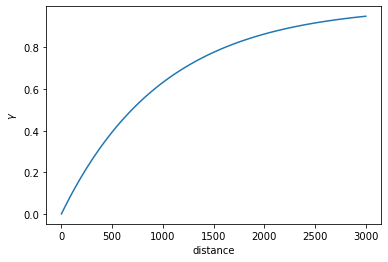

In [16]:
# exponential variogram for spatially varying parameters
v_space = pyemu.geostats.ExpVario(contribution=1.0, #sill
                                    a=1000, # range of correlation; length units of the model. In our case 'meters'
                                    anisotropy=1.0, #name says it all
                                    bearing=0.0 #angle in degrees East of North corresponding to anisotropy ellipse
                                    )

# geostatistical structure for spatially varying parameters
grid_gs = pyemu.geostats.GeoStruct(variograms=v_space, transform='log') 

# plot the gs if you like:
grid_gs.plot()

In [17]:
# exponential variogram for time varying parameters
v_time = pyemu.geostats.ExpVario(contribution=1.0, #sill
                                    a=60, # range of correlation; length time units (days)
                                    anisotropy=1.0, #do not change for 1-D time
                                    bearing=0.0 #do not change for 1-D time
                                    )

# geostatistical structure for time varying parameters
temporal_gs = pyemu.geostats.GeoStruct(variograms=v_time, transform='none') 

#### 5.3. Add Parameters

Let's start by adding parameters of hydraulic properties that vary in space (but not time) and which are housed in array-type files (e.g. Kh, Kv, Ss, Sy). We will start by demonstrating step-by-step for Kh.

First, find all the external array files that contain Kh values. In our case, these are the files with "npf_k_" in the file name. As you can see below, there is one file for each model layer. 

In [18]:
tag = "npf_k_"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
print(files)

['freyberg6.npf_k_layer1.txt', 'freyberg6.npf_k_layer2.txt', 'freyberg6.npf_k_layer3.txt']


Let's setup multiple spatial scales of parameters for Kh. To do this we will use three of the parameter "types" described above. The coarse scale will be a `constant` single value for each array. The medium scale will `pilot points`. The finest scale will use parameters as the `grid` scale (a unique parameter for each model cell!)

Each scale of parameters will work with the others as multipliers with the existing Kh arrays. (This all happens at runtime as part of the "model run" script.) Think of the scales as dials that PEST(++) can turn to improve the fit. The "coarse" scale is one big dial that alows PEST to move everything at once. The "medium" dials are few (but not too many) that allow PEST to adjust broad areas, but not making eveything move. The "fine" scales are lots of small dials that allow PEST(++) to have very detailed control, tweaking parameter values within very small areas. 

However, because we are working with parameter `multipliers`, we will need to specify two sets of parameter bounds: 
 - `upper_bound` and `lower_bound` are the standard control file bounds, while
 - `ult_ubound` and `ult_lbound` are bounds that are applied at runtime to the resulting (multiplied out) model input array. 
 
Since we are using sets of multipliers, it is important to make sure we keep the resulting model input arrays within the range of realistic values.

#### 5.3.1. Array Files

We will first demonstrate steb-by-step for `freyberg6.npf_k_layer1.txt`. We will start with grid scale parameters. These are multipliers assigned to each individual value in the array.

We start by getting the idomain array. As our model has inactive cells, this heps us avoid adding unncessary parameters. It is also required later when generating pilot points.

In [19]:
# as IDOMIAN is the same in all layers, we can use any layer
ib = gwf.dis.idomain.get_data(layer=0)

In [20]:
f = 'freyberg6.npf_k_layer1.txt'

# grid (fine) scale parameters
df_gr = pf.add_parameters(f,
                zone_array=ib, #as we have inactie model cells, we can avoid assigning these as parameters
                par_type="grid", #specify the type, these will be unique parameters for each cell
                geostruct=grid_gs, # the gestatisical structure for spatial correlation 
                par_name_base=f.split('.')[1]+"_gr", #specify a parameter name base that allows us to easily identify the filename and parameter type. "_gr" for "grid", and so forth.
                pargp=f.split('.')[1]+"_gr", #likewise for the parameter group name
                lower_bound=0.2, upper_bound=5.0, #parameter lower and upper bound
                ult_ubound=100, ult_lbound=0.01 # The ultimate bounds for multiplied model input values. Here we are stating that, after accounting for all multipliers, Kh cannot exceed these values. Very important with multipliers
                )

2022-03-02 11:49:03.581740 starting: adding grid type m style parameters for file(s) ['freyberg6.npf_k_layer1.txt']
2022-03-02 11:49:03.582728 starting: loading array freyberg6_template\freyberg6.npf_k_layer1.txt
2022-03-02 11:49:03.583709 finished: loading array freyberg6_template\freyberg6.npf_k_layer1.txt took: 0:00:00.000981
2022-03-02 11:49:03.583709 loaded array 'freyberg_mf6\freyberg6.npf_k_layer1.txt' of shape (40, 20)
2022-03-02 11:49:03.584747 starting: writing array-style template file 'freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl'
2022-03-02 11:49:03.584747 starting: writing template file freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl for ['npf_k_layer1_gr_inst:0']
2022-03-02 11:49:03.594718 finished: writing template file freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl for ['npf_k_layer1_gr_inst:0'] took: 0:00:00.009971
2022-03-02 11:49:03.594718 starting: writing array-based template file 'freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl'
2022-0

As when adding observations,  `pf.add_parameters()` returns a dataframe. Take a look. You may recognize alot of the information that appears in a PEST `*parameter data` section. All of this is still only housed in memory for now. We will write the PEST control file later on.

In [21]:
df_gr.head()

,parnme,parval1,i,j,x,y,pargp,tpl_filename,input_filename,partype,partrans,parubnd,parlbnd,parchglim,dercom,scale,offset
pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:0_x:125.00_y:9875.00_zone:1,pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:0_x:125.00_y:9875.00_zone:1,1.0,0,0,125.0,9875.0,npf_k_layer1_gr,freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl,freyberg6_template\mult\npf_k_layer1_gr_inst0_grid.csv,grid,log,5.0,0.2,factor,1,1.0,0.0
pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:1_x:375.00_y:9875.00_zone:1,pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:1_x:375.00_y:9875.00_zone:1,1.0,0,1,375.0,9875.0,npf_k_layer1_gr,freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl,freyberg6_template\mult\npf_k_layer1_gr_inst0_grid.csv,grid,log,5.0,0.2,factor,1,1.0,0.0
pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:2_x:625.00_y:9875.00_zone:1,pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:2_x:625.00_y:9875.00_zone:1,1.0,0,2,625.0,9875.0,npf_k_layer1_gr,freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl,freyberg6_template\mult\npf_k_layer1_gr_inst0_grid.csv,grid,log,5.0,0.2,factor,1,1.0,0.0
pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:3_x:875.00_y:9875.00_zone:1,pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:3_x:875.00_y:9875.00_zone:1,1.0,0,3,875.0,9875.0,npf_k_layer1_gr,freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl,freyberg6_template\mult\npf_k_layer1_gr_inst0_grid.csv,grid,log,5.0,0.2,factor,1,1.0,0.0
pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:4_x:1125.00_y:9875.00_zone:1,pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:4_x:1125.00_y:9875.00_zone:1,1.0,0,4,1125.0,9875.0,npf_k_layer1_gr,freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl,freyberg6_template\mult\npf_k_layer1_gr_inst0_grid.csv,grid,log,5.0,0.2,factor,1,1.0,0.0


Now, we add pilot point (medium scale) multiplier parameters to the same model input file. These multipliers are assigned to pilot points, which are subsequently interpolated to values in the array.

You can add pilot points in two ways:

1. `PstFrom` can generate them for you on a regular grid or 
2. you can supply `PstFrom` with existing pilot point location information. 

When you change `par_type` to "pilotpoints", by default, a regular grid of pilot points is setup using a default `pp_space` value of 10 (which is every 10th row and column). You can chnge this spacing by passing a integer to `pp_space` (as demonstrated below). 

Alternatively you can specify a filename or dataframe with pilot point locations. If you supply `pp_space` as a `str` it is assumed to be a filename. The extension is the guide: ".csv" for dataframe, ".shp" for shapefile (point-type). Anything else and the file is assumed to be a pilot points file type. The dataframe (or .csv file) must have "name", "x", and "y" as columns - it can have more, but must have those. 

In [22]:
# pilot point (medium) scale parameters
df_pp = pf.add_parameters(f,
                    zone_array=ib,
                    par_type="pilotpoints",
                    geostruct=grid_gs,
                    par_name_base=f.split('.')[1]+"_pp",
                    pargp=f.split('.')[1]+"_pp",
                    lower_bound=0.2,upper_bound=5.0,
                    ult_ubound=100, ult_lbound=0.01,
                    pp_space=4) # `PstFrom` will generate a unifrom grid of pilot points in every 4th row and column

2022-03-02 11:49:03.620610 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k_layer1.txt']
2022-03-02 11:49:03.621607 starting: loading array freyberg6_template\freyberg6.npf_k_layer1.txt
2022-03-02 11:49:03.622605 finished: loading array freyberg6_template\freyberg6.npf_k_layer1.txt took: 0:00:00.000998
2022-03-02 11:49:03.622605 loaded array 'freyberg_mf6\freyberg6.npf_k_layer1.txt' of shape (40, 20)
2022-03-02 11:49:03.623602 starting: writing array-style template file 'freyberg6_template\npf_k_layer1_pp_inst0_pilotpoints.csv.tpl'
2022-03-02 11:49:03.623602 starting: setting up pilot point parameters
2022-03-02 11:49:03.623602 No spatial reference (containing cell spacing) passed.
2022-03-02 11:49:03.623602 OK - using spatial reference in parent object.
2022-03-02 11:49:03.678285 32 pilot point parameters created
2022-03-02 11:49:03.678285 pilot point 'pargp':npf_k_layer1_pp
2022-03-02 11:49:03.678285 finished: setting up pilot point parameters took: 

starting 0
starting 1


starting 2
starting 3


starting 4
starting 5


starting 6
starting 7


starting 8
starting 9


took 3.322027 seconds
2022-03-02 11:49:07.040871 finished: calculating factors for pargp=npf_k_layer1_pp took: 0:00:03.357930
2022-03-02 11:49:07.040871 starting: writing array-based template file 'freyberg6_template\npf_k_layer1_pp_inst0pp.dat.tpl'
2022-03-02 11:49:07.040871 saving zone array freyberg6_template\npf_k_layer1_pp_inst0pp.dat.zone for tpl file freyberg6_template\npf_k_layer1_pp_inst0pp.dat.tpl
2022-03-02 11:49:07.043863 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k_layer1.txt'] took: 0:00:03.423253


Lastly, add the constant (coarse) parameter multiplier. This is a single multiplier value applied to all values in the array. 

In [23]:
# constant (coarse) scale parameters
df_cst = pf.add_parameters(f,
                    zone_array=ib,
                    par_type="constant",
                    geostruct=grid_gs,
                    par_name_base=f.split('.')[1]+"_cn",
                    pargp=f.split('.')[1]+"_cn",
                    lower_bound=0.2,upper_bound=5.0,
                    ult_ubound=100, ult_lbound=0.01)

2022-03-02 11:49:07.049343 starting: adding constant type m style parameters for file(s) ['freyberg6.npf_k_layer1.txt']
2022-03-02 11:49:07.050309 starting: loading array freyberg6_template\freyberg6.npf_k_layer1.txt
2022-03-02 11:49:07.051307 finished: loading array freyberg6_template\freyberg6.npf_k_layer1.txt took: 0:00:00.000998
2022-03-02 11:49:07.051307 loaded array 'freyberg_mf6\freyberg6.npf_k_layer1.txt' of shape (40, 20)
2022-03-02 11:49:07.052304 starting: writing array-style template file 'freyberg6_template\npf_k_layer1_cn_inst0_constant.csv.tpl'
2022-03-02 11:49:07.053252 starting: writing template file freyberg6_template\npf_k_layer1_cn_inst0_constant.csv.tpl for ['npf_k_layer1_cn_inst:0']
2022-03-02 11:49:07.058240 finished: writing template file freyberg6_template\npf_k_layer1_cn_inst0_constant.csv.tpl for ['npf_k_layer1_cn_inst:0'] took: 0:00:00.004988
2022-03-02 11:49:07.058240 starting: writing array-based template file 'freyberg6_template\npf_k_layer1_cn_inst0_cons

Let's do that for Kh in the other layers. We are going to be doing this a few times, so lets write a function.

In [24]:
def add_mult_pars(f, lb=0.2, ub=5.0, ulb=0.01, uub=100):
    # grid (fine) scale parameters
    pf.add_parameters(f,
                    zone_array=ib,
                    par_type="grid", #specify the type, these will be unique parameters for each cell
                    geostruct=grid_gs, # the gestatisical structure for spatial correlation 
                    par_name_base=f.split('.')[1]+"_gr", #specify a parameter name base that allows us to easily identify the filename and parameter type. "_gr" for "grid", and so forth.
                    pargp=f.split('.')[1]+"_gr", #likewise for the parameter group name
                    lower_bound=lb, upper_bound=ub, #parameter lower and upper bound
                    ult_ubound=uub, ult_lbound=ulb # The ultimate bounds for multiplied model input values. Here we are stating that, after accounting for all multipliers, Kh cannot exceed these values. Very important with multipliers
                    )
                    
    # pilot point (medium) scale parameters
    pf.add_parameters(f,
                        zone_array=ib,
                        par_type="pilotpoints",
                        geostruct=grid_gs,
                        par_name_base=f.split('.')[1]+"_pp",
                        pargp=f.split('.')[1]+"_pp",
                        lower_bound=lb, upper_bound=ub,
                        ult_ubound=uub, ult_lbound=ulb,
                        pp_space=4) # `PstFrom` will generate a unifrom grid of pilot points in every 4th row and column

    # constant (coarse) scale parameters
    pf.add_parameters(f,
                        zone_array=ib,
                        par_type="constant",
                        geostruct=grid_gs,
                        par_name_base=f.split('.')[1]+"_cn",
                        pargp=f.split('.')[1]+"_cn",
                        lower_bound=lb, upper_bound=ub,
                        ult_ubound=uub, ult_lbound=ulb)
    return

In [25]:
for f in files[1:]:
    add_mult_pars(f, lb=0.2, ub=5.0, ulb=0.01, uub=100)

2022-03-02 11:49:07.074353 starting: adding grid type m style parameters for file(s) ['freyberg6.npf_k_layer2.txt']
2022-03-02 11:49:07.074353 starting: loading array freyberg6_template\freyberg6.npf_k_layer2.txt
2022-03-02 11:49:07.075350 finished: loading array freyberg6_template\freyberg6.npf_k_layer2.txt took: 0:00:00.000997
2022-03-02 11:49:07.075350 loaded array 'freyberg_mf6\freyberg6.npf_k_layer2.txt' of shape (40, 20)
2022-03-02 11:49:07.077344 starting: writing array-style template file 'freyberg6_template\npf_k_layer2_gr_inst0_grid.csv.tpl'
2022-03-02 11:49:07.077344 starting: writing template file freyberg6_template\npf_k_layer2_gr_inst0_grid.csv.tpl for ['npf_k_layer2_gr_inst:0']
2022-03-02 11:49:07.086349 finished: writing template file freyberg6_template\npf_k_layer2_gr_inst0_grid.csv.tpl for ['npf_k_layer2_gr_inst:0'] took: 0:00:00.009005
2022-03-02 11:49:07.086349 starting: writing array-based template file 'freyberg6_template\npf_k_layer2_gr_inst0_grid.csv.tpl'
2022-0

2022-03-02 11:49:07.191813 starting: writing array-style template file 'freyberg6_template\npf_k_layer3_pp_inst0_pilotpoints.csv.tpl'
2022-03-02 11:49:07.191813 starting: setting up pilot point parameters
2022-03-02 11:49:07.191813 No spatial reference (containing cell spacing) passed.
2022-03-02 11:49:07.191813 OK - using spatial reference in parent object.
2022-03-02 11:49:07.245906 32 pilot point parameters created


2022-03-02 11:49:07.246877 pilot point 'pargp':npf_k_layer3_pp
2022-03-02 11:49:07.246877 finished: setting up pilot point parameters took: 0:00:00.055064
2022-03-02 11:49:07.251884 starting: writing array-based template file 'freyberg6_template\npf_k_layer3_pp_inst0pp.dat.tpl'


2022-03-02 11:49:07.251884 saving zone array freyberg6_template\npf_k_layer3_pp_inst0pp.dat.zone for tpl file freyberg6_template\npf_k_layer3_pp_inst0pp.dat.tpl
2022-03-02 11:49:07.255876 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k_layer3.txt'] took: 0:00:00.067012
2022-03-02 11:49:07.255876 starting: adding constant type m style parameters for file(s) ['freyberg6.npf_k_layer3.txt']
2022-03-02 11:49:07.255876 starting: loading array freyberg6_template\freyberg6.npf_k_layer3.txt
2022-03-02 11:49:07.256843 finished: loading array freyberg6_template\freyberg6.npf_k_layer3.txt took: 0:00:00.000967
2022-03-02 11:49:07.257726 loaded array 'freyberg_mf6\freyberg6.npf_k_layer3.txt' of shape (40, 20)
2022-03-02 11:49:07.258725 starting: writing array-style template file 'freyberg6_template\npf_k_layer3_cn_inst0_constant.csv.tpl'
2022-03-02 11:49:07.258725 starting: writing template file freyberg6_template\npf_k_layer3_cn_inst0_constant.csv.tpl for ['npf_k_

Well...hot damn, wasn't that easy? Let's speed through the other array parameter files.

In [26]:
# for Kv
tag = "npf_k33"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
for f in files:
    add_mult_pars(f, lb=0.2, ub=5.0, ulb=0.01, uub=100)

# for Ss
tag = "sto_ss"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
# only for layer 2 and 3; we aren't monsters
for f in files[1:]: 
    add_mult_pars(f, lb=0.2, ub=5.0, ulb=1e-6, uub=1e-3)

# For Sy
tag = "sto_sy"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
# only for layer 1
f = files[0]
add_mult_pars(f, lb=0.2, ub=5.0, ulb=0.01, uub=0.4)


2022-03-02 11:49:07.277675 starting: adding grid type m style parameters for file(s) ['freyberg6.npf_k33_layer1.txt']
2022-03-02 11:49:07.277675 starting: loading array freyberg6_template\freyberg6.npf_k33_layer1.txt
2022-03-02 11:49:07.278672 finished: loading array freyberg6_template\freyberg6.npf_k33_layer1.txt took: 0:00:00.000997
2022-03-02 11:49:07.278672 loaded array 'freyberg_mf6\freyberg6.npf_k33_layer1.txt' of shape (40, 20)
2022-03-02 11:49:07.280666 starting: writing array-style template file 'freyberg6_template\npf_k33_layer1_gr_inst0_grid.csv.tpl'
2022-03-02 11:49:07.280666 starting: writing template file freyberg6_template\npf_k33_layer1_gr_inst0_grid.csv.tpl for ['npf_k33_layer1_gr_inst:0']
2022-03-02 11:49:07.289671 finished: writing template file freyberg6_template\npf_k33_layer1_gr_inst0_grid.csv.tpl for ['npf_k33_layer1_gr_inst:0'] took: 0:00:00.009005
2022-03-02 11:49:07.289671 starting: writing array-based template file 'freyberg6_template\npf_k33_layer1_gr_inst0_

2022-03-02 11:49:07.379039 starting: writing template file freyberg6_template\npf_k33_layer2_gr_inst0_grid.csv.tpl for ['npf_k33_layer2_gr_inst:0']
2022-03-02 11:49:07.388967 finished: writing template file freyberg6_template\npf_k33_layer2_gr_inst0_grid.csv.tpl for ['npf_k33_layer2_gr_inst:0'] took: 0:00:00.009928
2022-03-02 11:49:07.388967 starting: writing array-based template file 'freyberg6_template\npf_k33_layer2_gr_inst0_grid.csv.tpl'
2022-03-02 11:49:07.389978 saving zone array freyberg6_template\npf_k33_layer2_gr_inst0_grid.csv.zone for tpl file freyberg6_template\npf_k33_layer2_gr_inst0_grid.csv.tpl
2022-03-02 11:49:07.394981 finished: adding grid type m style parameters for file(s) ['freyberg6.npf_k33_layer2.txt'] took: 0:00:00.019950
2022-03-02 11:49:07.394981 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k33_layer2.txt']
2022-03-02 11:49:07.394981 starting: loading array freyberg6_template\freyberg6.npf_k33_layer2.txt
2022-03-02 11:49:07.

2022-03-02 11:49:07.451025 32 pilot point parameters created


2022-03-02 11:49:07.451025 pilot point 'pargp':npf_k33_layer2_pp
2022-03-02 11:49:07.452049 finished: setting up pilot point parameters took: 0:00:00.054104
2022-03-02 11:49:07.457050 starting: writing array-based template file 'freyberg6_template\npf_k33_layer2_pp_inst0pp.dat.tpl'


2022-03-02 11:49:07.457050 saving zone array freyberg6_template\npf_k33_layer2_pp_inst0pp.dat.zone for tpl file freyberg6_template\npf_k33_layer2_pp_inst0pp.dat.tpl
2022-03-02 11:49:07.461027 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k33_layer2.txt'] took: 0:00:00.066046
2022-03-02 11:49:07.461027 starting: adding constant type m style parameters for file(s) ['freyberg6.npf_k33_layer2.txt']
2022-03-02 11:49:07.461027 starting: loading array freyberg6_template\freyberg6.npf_k33_layer2.txt
2022-03-02 11:49:07.462025 finished: loading array freyberg6_template\freyberg6.npf_k33_layer2.txt took: 0:00:00.000998
2022-03-02 11:49:07.462025 loaded array 'freyberg_mf6\freyberg6.npf_k33_layer2.txt' of shape (40, 20)
2022-03-02 11:49:07.463024 starting: writing array-style template file 'freyberg6_template\npf_k33_layer2_cn_inst0_constant.csv.tpl'
2022-03-02 11:49:07.464021 starting: writing template file freyberg6_template\npf_k33_layer2_cn_inst0_constant.cs

2022-03-02 11:49:07.567742 starting: adding grid type m style parameters for file(s) ['freyberg6.sto_ss_layer2.txt']
2022-03-02 11:49:07.567742 starting: loading array freyberg6_template\freyberg6.sto_ss_layer2.txt
2022-03-02 11:49:07.568735 finished: loading array freyberg6_template\freyberg6.sto_ss_layer2.txt took: 0:00:00.000993
2022-03-02 11:49:07.568735 loaded array 'freyberg_mf6\freyberg6.sto_ss_layer2.txt' of shape (40, 20)
2022-03-02 11:49:07.570734 starting: writing array-style template file 'freyberg6_template\sto_ss_layer2_gr_inst0_grid.csv.tpl'
2022-03-02 11:49:07.570734 starting: writing template file freyberg6_template\sto_ss_layer2_gr_inst0_grid.csv.tpl for ['sto_ss_layer2_gr_inst:0']
2022-03-02 11:49:07.580678 finished: writing template file freyberg6_template\sto_ss_layer2_gr_inst0_grid.csv.tpl for ['sto_ss_layer2_gr_inst:0'] took: 0:00:00.009944
2022-03-02 11:49:07.580678 starting: writing array-based template file 'freyberg6_template\sto_ss_layer2_gr_inst0_grid.csv.t

2022-03-02 11:49:07.640252 finished: setting up pilot point parameters took: 0:00:00.052564
2022-03-02 11:49:07.645239 starting: writing array-based template file 'freyberg6_template\sto_ss_layer2_pp_inst0pp.dat.tpl'


2022-03-02 11:49:07.645239 saving zone array freyberg6_template\sto_ss_layer2_pp_inst0pp.dat.zone for tpl file freyberg6_template\sto_ss_layer2_pp_inst0pp.dat.tpl
2022-03-02 11:49:07.649228 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.sto_ss_layer2.txt'] took: 0:00:00.064532
2022-03-02 11:49:07.649907 starting: adding constant type m style parameters for file(s) ['freyberg6.sto_ss_layer2.txt']
2022-03-02 11:49:07.649907 starting: loading array freyberg6_template\freyberg6.sto_ss_layer2.txt
2022-03-02 11:49:07.650906 finished: loading array freyberg6_template\freyberg6.sto_ss_layer2.txt took: 0:00:00.000999
2022-03-02 11:49:07.650906 loaded array 'freyberg_mf6\freyberg6.sto_ss_layer2.txt' of shape (40, 20)
2022-03-02 11:49:07.651903 starting: writing array-style template file 'freyberg6_template\sto_ss_layer2_cn_inst0_constant.csv.tpl'
2022-03-02 11:49:07.651903 starting: writing template file freyberg6_template\sto_ss_layer2_cn_inst0_constant.csv.tpl for

2022-03-02 11:49:07.755626 starting: writing array-based template file 'freyberg6_template\sto_ss_layer3_cn_inst0_constant.csv.tpl'
2022-03-02 11:49:07.755626 saving zone array freyberg6_template\sto_ss_layer3_cn_inst0_constant.csv.zone for tpl file freyberg6_template\sto_ss_layer3_cn_inst0_constant.csv.tpl
2022-03-02 11:49:07.760641 finished: adding constant type m style parameters for file(s) ['freyberg6.sto_ss_layer3.txt'] took: 0:00:00.013991
2022-03-02 11:49:07.761610 starting: adding grid type m style parameters for file(s) ['freyberg6.sto_sy_layer1.txt']
2022-03-02 11:49:07.761610 starting: loading array freyberg6_template\freyberg6.sto_sy_layer1.txt
2022-03-02 11:49:07.762607 finished: loading array freyberg6_template\freyberg6.sto_sy_layer1.txt took: 0:00:00.000997
2022-03-02 11:49:07.762607 loaded array 'freyberg_mf6\freyberg6.sto_sy_layer1.txt' of shape (40, 20)
2022-03-02 11:49:07.763604 starting: writing array-style template file 'freyberg6_template\sto_sy_layer1_gr_inst0_

2022-03-02 11:49:07.832421 pilot point 'pargp':sto_sy_layer1_pp
2022-03-02 11:49:07.833417 finished: setting up pilot point parameters took: 0:00:00.052858
2022-03-02 11:49:07.838433 starting: writing array-based template file 'freyberg6_template\sto_sy_layer1_pp_inst0pp.dat.tpl'
2022-03-02 11:49:07.838433 saving zone array freyberg6_template\sto_sy_layer1_pp_inst0pp.dat.zone for tpl file freyberg6_template\sto_sy_layer1_pp_inst0pp.dat.tpl
2022-03-02 11:49:07.841425 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.sto_sy_layer1.txt'] took: 0:00:00.062830
2022-03-02 11:49:07.841425 starting: adding constant type m style parameters for file(s) ['freyberg6.sto_sy_layer1.txt']
2022-03-02 11:49:07.842422 starting: loading array freyberg6_template\freyberg6.sto_sy_layer1.txt
2022-03-02 11:49:07.843391 finished: loading array freyberg6_template\freyberg6.sto_sy_layer1.txt took: 0:00:00.000969
2022-03-02 11:49:07.843391 loaded array 'freyberg_mf6\freyberg6.sto_sy_la

#### 5.3.2. Spatial and Temporal Correlation

Now, you may be thinking "shouldn't recharge have temporal correlation as well?". 

Damn straight it should. Now, this requires a little trickery.

First we need to construct a container of stress period datetimes. (This relies on specifying the start_datetime argument when instantiating `PstFrom`.) These datetime values will specify the postion of parameters on the time-axis.



In [27]:
# build up a container of stress period start datetimes - this will
# be used to specify the datetime of each multipler parameter
start_datetime="1-1-2018"
dts = pd.to_datetime(start_datetime) + pd.to_timedelta(np.cumsum(sim.tdis.perioddata.array["perlen"]),unit='d')

dts

DatetimeIndex(['2018-01-02', '2018-02-02', '2018-03-03', '2018-04-03',
               '2018-05-03', '2018-06-03', '2018-07-03', '2018-08-03',
               '2018-09-03', '2018-10-03', '2018-11-03', '2018-12-03',
               '2019-01-03', '2019-02-03', '2019-03-03', '2019-04-03',
               '2019-05-03', '2019-06-03', '2019-07-03', '2019-08-03',
               '2019-09-03', '2019-10-03', '2019-11-03', '2019-12-03',
               '2020-01-03'],
              dtype='datetime64[ns]', freq=None)

If you use the same parameter group name (`pargp`) and same geostruct, `PstFrom` will treat parameters setup across different calls to `add_parameters()` as correlated.  In this case, we want to express temporal correlation in the recharge multiplier parameters. So, we use the same parameter group names for each stress period data file, and specify the `datetime` and `geostruct` arguments.

Including temporal correlation introduces an additional challenge. Interpolation between points that share a common coordinate creates all types of trouble. We are going to have many parameters during each stress period (a single point on the time-axis). To get around this challenge we need to be a bit sneaky.


First, we will apply the multiple *spatial* scales of parameter multiplers (`constant`, `pilot point` and `grid`) as we did for hyraulic properties. 

Then, we will asign an additional `constant` multiplier parameter for each recharge stress-period file (so, a single multiplier for all recharge paramaters for each stress period). We will specify temporal correlation for these `constant` multipliers. These will all have the same parameter group name, as discussed above. 

In [28]:
# for Recharge; 
tag = "rch_recharge"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
for f in files:
    # the spatial multiplier parameters; just use the same function
    add_mult_pars(f, lb=0.2, ub=5.0, ulb=2e-5, uub=2e-4)
    
    
    # multiplier that includes temporal correlation
    # get the stress period number from the file name
    kper = int(f.split('.')[1].split('_')[-1]) - 1  
    
    # add the constant parameters (with temporal correlation)
    pf.add_parameters(filenames=f,
                    zone_array=ib,
                    par_type="constant",
                    par_name_base=f.split('.')[1]+"_tcn",
                    pargp=f.split('.')[1]+"_tcn",
                    lower_bound=0.5, upper_bound=1.5,
                    ult_ubound=2e-4, ult_lbound=2e-5,
                    datetime=dts[kper], # this places the parameter value on the "time axis"
                    geostruct=temporal_gs)

2022-03-02 11:49:07.871304 starting: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_1.txt']
2022-03-02 11:49:07.871304 starting: loading array freyberg6_template\freyberg6.rch_recharge_1.txt
2022-03-02 11:49:07.872301 finished: loading array freyberg6_template\freyberg6.rch_recharge_1.txt took: 0:00:00.000997
2022-03-02 11:49:07.872301 loaded array 'freyberg_mf6\freyberg6.rch_recharge_1.txt' of shape (40, 20)
2022-03-02 11:49:07.874295 starting: writing array-style template file 'freyberg6_template\rch_recharge_1_gr_inst0_grid.csv.tpl'
2022-03-02 11:49:07.874295 starting: writing template file freyberg6_template\rch_recharge_1_gr_inst0_grid.csv.tpl for ['rch_recharge_1_gr_inst:0']
2022-03-02 11:49:07.883304 finished: writing template file freyberg6_template\rch_recharge_1_gr_inst0_grid.csv.tpl for ['rch_recharge_1_gr_inst:0'] took: 0:00:00.009009
2022-03-02 11:49:07.883304 starting: writing array-based template file 'freyberg6_template\rch_recharge_1_gr_inst0_

2022-03-02 11:49:07.942142 finished: setting up pilot point parameters took: 0:00:00.050892
2022-03-02 11:49:07.947100 starting: writing array-based template file 'freyberg6_template\rch_recharge_1_pp_inst0pp.dat.tpl'
2022-03-02 11:49:07.948099 saving zone array freyberg6_template\rch_recharge_1_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_1_pp_inst0pp.dat.tpl
2022-03-02 11:49:07.952120 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_1.txt'] took: 0:00:00.062835
2022-03-02 11:49:07.952120 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_1.txt']
2022-03-02 11:49:07.952120 starting: loading array freyberg6_template\freyberg6.rch_recharge_1.txt
2022-03-02 11:49:07.953086 finished: loading array freyberg6_template\freyberg6.rch_recharge_1.txt took: 0:00:00.000966
2022-03-02 11:49:07.953086 loaded array 'freyberg_mf6\freyberg6.rch_recharge_1.txt' of shape (40, 20)
2022-03-02 11:49:07.955079 s

2022-03-02 11:49:08.057825 32 pilot point parameters created


2022-03-02 11:49:08.057825 pilot point 'pargp':rch_recharge_10_pp
2022-03-02 11:49:08.057825 finished: setting up pilot point parameters took: 0:00:00.051951
2022-03-02 11:49:08.062783 starting: writing array-based template file 'freyberg6_template\rch_recharge_10_pp_inst0pp.dat.tpl'
2022-03-02 11:49:08.062783 saving zone array freyberg6_template\rch_recharge_10_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_10_pp_inst0pp.dat.tpl
2022-03-02 11:49:08.066763 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_10.txt'] took: 0:00:00.064842
2022-03-02 11:49:08.066763 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_10.txt']
2022-03-02 11:49:08.066763 starting: loading array freyberg6_template\freyberg6.rch_recharge_10.txt
2022-03-02 11:49:08.067740 finished: loading array freyberg6_template\freyberg6.rch_recharge_10.txt took: 0:00:00.000977
2022-03-02 11:49:08.068776 loaded array 'freyberg_mf6\fre

2022-03-02 11:49:08.165608 32 pilot point parameters created
2022-03-02 11:49:08.166606 pilot point 'pargp':rch_recharge_11_pp
2022-03-02 11:49:08.166606 finished: setting up pilot point parameters took: 0:00:00.050847
2022-03-02 11:49:08.171620 starting: writing array-based template file 'freyberg6_template\rch_recharge_11_pp_inst0pp.dat.tpl'
2022-03-02 11:49:08.171620 saving zone array freyberg6_template\rch_recharge_11_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_11_pp_inst0pp.dat.tpl
2022-03-02 11:49:08.174613 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_11.txt'] took: 0:00:00.061817
2022-03-02 11:49:08.175590 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_11.txt']
2022-03-02 11:49:08.175590 starting: loading array freyberg6_template\freyberg6.rch_recharge_11.txt
2022-03-02 11:49:08.176608 finished: loading array freyberg6_template\freyberg6.rch_recharge_11.txt took: 0:00:00.001

2022-03-02 11:49:08.276313 32 pilot point parameters created
2022-03-02 11:49:08.277309 pilot point 'pargp':rch_recharge_12_pp
2022-03-02 11:49:08.277309 finished: setting up pilot point parameters took: 0:00:00.053824
2022-03-02 11:49:08.281329 starting: writing array-based template file 'freyberg6_template\rch_recharge_12_pp_inst0pp.dat.tpl'
2022-03-02 11:49:08.282324 saving zone array freyberg6_template\rch_recharge_12_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_12_pp_inst0pp.dat.tpl
2022-03-02 11:49:08.285316 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_12.txt'] took: 0:00:00.064826
2022-03-02 11:49:08.285316 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_12.txt']
2022-03-02 11:49:08.286290 starting: loading array freyberg6_template\freyberg6.rch_recharge_12.txt
2022-03-02 11:49:08.286290 finished: loading array freyberg6_template\freyberg6.rch_recharge_12.txt took: 0:00:00
202

2022-03-02 11:49:08.386816 32 pilot point parameters created
2022-03-02 11:49:08.387814 pilot point 'pargp':rch_recharge_13_pp
2022-03-02 11:49:08.387814 finished: setting up pilot point parameters took: 0:00:00.053889
2022-03-02 11:49:08.392833 starting: writing array-based template file 'freyberg6_template\rch_recharge_13_pp_inst0pp.dat.tpl'
2022-03-02 11:49:08.392833 saving zone array freyberg6_template\rch_recharge_13_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_13_pp_inst0pp.dat.tpl
2022-03-02 11:49:08.395822 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_13.txt'] took: 0:00:00.064860
2022-03-02 11:49:08.396850 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_13.txt']
2022-03-02 11:49:08.396850 starting: loading array freyberg6_template\freyberg6.rch_recharge_13.txt
2022-03-02 11:49:08.397817 finished: loading array freyberg6_template\freyberg6.rch_recharge_13.txt took: 0:00:00.000

2022-03-02 11:49:08.499515 32 pilot point parameters created
2022-03-02 11:49:08.499515 pilot point 'pargp':rch_recharge_14_pp
2022-03-02 11:49:08.499515 finished: setting up pilot point parameters took: 0:00:00.054824
2022-03-02 11:49:08.504531 starting: writing array-based template file 'freyberg6_template\rch_recharge_14_pp_inst0pp.dat.tpl'
2022-03-02 11:49:08.504531 saving zone array freyberg6_template\rch_recharge_14_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_14_pp_inst0pp.dat.tpl
2022-03-02 11:49:08.508520 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_14.txt'] took: 0:00:00.066820
2022-03-02 11:49:08.509517 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_14.txt']
2022-03-02 11:49:08.509517 starting: loading array freyberg6_template\freyberg6.rch_recharge_14.txt
2022-03-02 11:49:08.510517 finished: loading array freyberg6_template\freyberg6.rch_recharge_14.txt took: 0:00:00.001

2022-03-02 11:49:08.610247 32 pilot point parameters created
2022-03-02 11:49:08.610247 pilot point 'pargp':rch_recharge_15_pp
2022-03-02 11:49:08.610247 finished: setting up pilot point parameters took: 0:00:00.050863
2022-03-02 11:49:08.615234 starting: writing array-based template file 'freyberg6_template\rch_recharge_15_pp_inst0pp.dat.tpl'
2022-03-02 11:49:08.616254 saving zone array freyberg6_template\rch_recharge_15_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_15_pp_inst0pp.dat.tpl
2022-03-02 11:49:08.619248 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_15.txt'] took: 0:00:00.062851
2022-03-02 11:49:08.619248 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_15.txt']
2022-03-02 11:49:08.619248 starting: loading array freyberg6_template\freyberg6.rch_recharge_15.txt
2022-03-02 11:49:08.620245 finished: loading array freyberg6_template\freyberg6.rch_recharge_15.txt took: 0:00:00.000

2022-03-02 11:49:08.724079 32 pilot point parameters created
2022-03-02 11:49:08.724079 pilot point 'pargp':rch_recharge_16_pp
2022-03-02 11:49:08.725076 finished: setting up pilot point parameters took: 0:00:00.053886
2022-03-02 11:49:08.729036 starting: writing array-based template file 'freyberg6_template\rch_recharge_16_pp_inst0pp.dat.tpl'
2022-03-02 11:49:08.730033 saving zone array freyberg6_template\rch_recharge_16_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_16_pp_inst0pp.dat.tpl
2022-03-02 11:49:08.733025 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_16.txt'] took: 0:00:00.064554
2022-03-02 11:49:08.733025 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_16.txt']
2022-03-02 11:49:08.734022 starting: loading array freyberg6_template\freyberg6.rch_recharge_16.txt
2022-03-02 11:49:08.735020 finished: loading array freyberg6_template\freyberg6.rch_recharge_16.txt took: 0:00:00.000

2022-03-02 11:49:08.783889 starting: setting up pilot point parameters
2022-03-02 11:49:08.783889 No spatial reference (containing cell spacing) passed.
2022-03-02 11:49:08.783889 OK - using spatial reference in parent object.
2022-03-02 11:49:08.834274 32 pilot point parameters created
2022-03-02 11:49:08.834274 pilot point 'pargp':rch_recharge_17_pp
2022-03-02 11:49:08.834274 finished: setting up pilot point parameters took: 0:00:00.050385
2022-03-02 11:49:08.839249 starting: writing array-based template file 'freyberg6_template\rch_recharge_17_pp_inst0pp.dat.tpl'
2022-03-02 11:49:08.839249 saving zone array freyberg6_template\rch_recharge_17_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_17_pp_inst0pp.dat.tpl
2022-03-02 11:49:08.843131 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_17.txt'] took: 0:00:00.062234
2022-03-02 11:49:08.843131 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge

2022-03-02 11:49:08.944053 32 pilot point parameters created
2022-03-02 11:49:08.945052 pilot point 'pargp':rch_recharge_18_pp
2022-03-02 11:49:08.945052 finished: setting up pilot point parameters took: 0:00:00.052888
2022-03-02 11:49:08.950068 starting: writing array-based template file 'freyberg6_template\rch_recharge_18_pp_inst0pp.dat.tpl'
2022-03-02 11:49:08.950068 saving zone array freyberg6_template\rch_recharge_18_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_18_pp_inst0pp.dat.tpl
2022-03-02 11:49:08.953061 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_18.txt'] took: 0:00:00.062884
2022-03-02 11:49:08.954071 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_18.txt']
2022-03-02 11:49:08.954071 starting: loading array freyberg6_template\freyberg6.rch_recharge_18.txt
2022-03-02 11:49:08.955054 finished: loading array freyberg6_template\freyberg6.rch_recharge_18.txt took: 0:00:00.000

2022-03-02 11:49:08.975999 starting: writing array-based template file 'freyberg6_template\rch_recharge_18_tcn_inst0_constant.csv.tpl'
2022-03-02 11:49:08.976990 saving zone array freyberg6_template\rch_recharge_18_tcn_inst0_constant.csv.zone for tpl file freyberg6_template\rch_recharge_18_tcn_inst0_constant.csv.tpl
2022-03-02 11:49:08.981983 finished: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_18.txt'] took: 0:00:00.014990
2022-03-02 11:49:08.981983 starting: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_19.txt']
2022-03-02 11:49:08.981983 starting: loading array freyberg6_template\freyberg6.rch_recharge_19.txt
2022-03-02 11:49:08.982997 finished: loading array freyberg6_template\freyberg6.rch_recharge_19.txt took: 0:00:00.001014
2022-03-02 11:49:08.982997 loaded array 'freyberg_mf6\freyberg6.rch_recharge_19.txt' of shape (40, 20)
2022-03-02 11:49:08.984973 starting: writing array-style template file 'freyberg6_template\rch_

2022-03-02 11:49:09.243702 32 pilot point parameters created
2022-03-02 11:49:09.243702 pilot point 'pargp':rch_recharge_2_pp
2022-03-02 11:49:09.243702 finished: setting up pilot point parameters took: 0:00:00.125079
2022-03-02 11:49:09.248834 starting: writing array-based template file 'freyberg6_template\rch_recharge_2_pp_inst0pp.dat.tpl'
2022-03-02 11:49:09.248834 saving zone array freyberg6_template\rch_recharge_2_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_2_pp_inst0pp.dat.tpl
2022-03-02 11:49:09.252854 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_2.txt'] took: 0:00:00.137229
2022-03-02 11:49:09.252854 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_2.txt']
2022-03-02 11:49:09.252854 starting: loading array freyberg6_template\freyberg6.rch_recharge_2.txt
2022-03-02 11:49:09.253821 finished: loading array freyberg6_template\freyberg6.rch_recharge_2.txt took: 0:00:00.000967
2022

2022-03-02 11:49:09.470802 32 pilot point parameters created
2022-03-02 11:49:09.471819 pilot point 'pargp':rch_recharge_21_pp
2022-03-02 11:49:09.471819 finished: setting up pilot point parameters took: 0:00:00.053850
2022-03-02 11:49:09.476826 starting: writing array-based template file 'freyberg6_template\rch_recharge_21_pp_inst0pp.dat.tpl'
2022-03-02 11:49:09.476826 saving zone array freyberg6_template\rch_recharge_21_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_21_pp_inst0pp.dat.tpl
2022-03-02 11:49:09.480800 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_21.txt'] took: 0:00:00.065811
2022-03-02 11:49:09.480800 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_21.txt']
2022-03-02 11:49:09.480800 starting: loading array freyberg6_template\freyberg6.rch_recharge_21.txt
2022-03-02 11:49:09.481802 finished: loading array freyberg6_template\freyberg6.rch_recharge_21.txt took: 0:00:00.001

2022-03-02 11:49:09.688249 32 pilot point parameters created
2022-03-02 11:49:09.688249 pilot point 'pargp':rch_recharge_23_pp
2022-03-02 11:49:09.688249 finished: setting up pilot point parameters took: 0:00:00.050863
2022-03-02 11:49:09.693236 starting: writing array-based template file 'freyberg6_template\rch_recharge_23_pp_inst0pp.dat.tpl'
2022-03-02 11:49:09.693236 saving zone array freyberg6_template\rch_recharge_23_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_23_pp_inst0pp.dat.tpl
2022-03-02 11:49:09.697225 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_23.txt'] took: 0:00:00.062827
2022-03-02 11:49:09.697673 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_23.txt']
2022-03-02 11:49:09.697673 starting: loading array freyberg6_template\freyberg6.rch_recharge_23.txt
2022-03-02 11:49:09.698672 finished: loading array freyberg6_template\freyberg6.rch_recharge_23.txt took: 0:00:00.000

2022-03-02 11:49:09.913127 32 pilot point parameters created
2022-03-02 11:49:09.913127 pilot point 'pargp':rch_recharge_25_pp
2022-03-02 11:49:09.913127 finished: setting up pilot point parameters took: 0:00:00.052887
2022-03-02 11:49:09.918085 starting: writing array-based template file 'freyberg6_template\rch_recharge_25_pp_inst0pp.dat.tpl'
2022-03-02 11:49:09.918085 saving zone array freyberg6_template\rch_recharge_25_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_25_pp_inst0pp.dat.tpl
2022-03-02 11:49:09.922074 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_25.txt'] took: 0:00:00.064826
2022-03-02 11:49:09.922074 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_25.txt']
2022-03-02 11:49:09.922074 starting: loading array freyberg6_template\freyberg6.rch_recharge_25.txt
2022-03-02 11:49:09.923071 finished: loading array freyberg6_template\freyberg6.rch_recharge_25.txt took: 0:00:00.000

2022-03-02 11:49:10.130509 32 pilot point parameters created
2022-03-02 11:49:10.130509 pilot point 'pargp':rch_recharge_4_pp
2022-03-02 11:49:10.131478 finished: setting up pilot point parameters took: 0:00:00.052239
2022-03-02 11:49:10.135495 starting: writing array-based template file 'freyberg6_template\rch_recharge_4_pp_inst0pp.dat.tpl'
2022-03-02 11:49:10.135495 saving zone array freyberg6_template\rch_recharge_4_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_4_pp_inst0pp.dat.tpl
2022-03-02 11:49:10.139484 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_4.txt'] took: 0:00:00.062207
2022-03-02 11:49:10.139484 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_4.txt']
2022-03-02 11:49:10.139484 starting: loading array freyberg6_template\freyberg6.rch_recharge_4.txt
2022-03-02 11:49:10.140470 finished: loading array freyberg6_template\freyberg6.rch_recharge_4.txt took: 0:00:00.000986
2022

2022-03-02 11:49:10.350298 32 pilot point parameters created
2022-03-02 11:49:10.350298 pilot point 'pargp':rch_recharge_6_pp
2022-03-02 11:49:10.350298 finished: setting up pilot point parameters took: 0:00:00.051101
2022-03-02 11:49:10.355316 starting: writing array-based template file 'freyberg6_template\rch_recharge_6_pp_inst0pp.dat.tpl'
2022-03-02 11:49:10.355316 saving zone array freyberg6_template\rch_recharge_6_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_6_pp_inst0pp.dat.tpl
2022-03-02 11:49:10.359304 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_6.txt'] took: 0:00:00.063099
2022-03-02 11:49:10.359304 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_6.txt']
2022-03-02 11:49:10.359304 starting: loading array freyberg6_template\freyberg6.rch_recharge_6.txt
2022-03-02 11:49:10.360300 finished: loading array freyberg6_template\freyberg6.rch_recharge_6.txt took: 0:00:00.000996
2022

2022-03-02 11:49:10.574539 32 pilot point parameters created
2022-03-02 11:49:10.574539 pilot point 'pargp':rch_recharge_8_pp
2022-03-02 11:49:10.574539 finished: setting up pilot point parameters took: 0:00:00.050895
2022-03-02 11:49:10.579494 starting: writing array-based template file 'freyberg6_template\rch_recharge_8_pp_inst0pp.dat.tpl'
2022-03-02 11:49:10.579494 saving zone array freyberg6_template\rch_recharge_8_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_8_pp_inst0pp.dat.tpl
2022-03-02 11:49:10.583524 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_8.txt'] took: 0:00:00.062832
2022-03-02 11:49:10.583524 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_8.txt']
2022-03-02 11:49:10.583524 starting: loading array freyberg6_template\freyberg6.rch_recharge_8.txt
2022-03-02 11:49:10.584481 finished: loading array freyberg6_template\freyberg6.rch_recharge_8.txt took: 0:00:00.000957
2022

### 5.3.3. List Files

Adding parameters from list-type files follows similar principles. As with observation files, they must be tabular. Certain columns are specified as index columns and are used to populate parameter names, as well as provide the parameters' spatial location. Other columns are specified as containing parameter values. 

Parameters can be `grid` or `constant`. As before, values can be assigned `directly`, as `multipliers` or as `additives`.

We will demonstrate for the boundary-condition input files. 

Starting off with GHBs. Let's inspect the folder. As you can see, there is a single input file (GHB parameters are assumed to not vary over time).

In [29]:
tag = "ghb_stress_period_data"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
print(files)

['freyberg6.ghb_stress_period_data_1.txt']


Since these boundaries are likely to be very influential, we want to include a robust representation of their uncertainty - both head and conductance and at multiple scales.  

Let's parameterize both GHB conductance and head:

 - For conductance, we shall use two scales of `multiplier` parameters (`constant` and `grid`).

 - For heads, multipliers are not ideal. Insead we will use `additive` parameters. Again, with a coarse and fine scale.

In [30]:
tag = "ghb_stress_period_data"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]

for f in files:
    # constant and grid scale multiplier conductance parameters
    name = 'ghbcond'
    pf.add_parameters(f,
                        par_type="grid",
                        geostruct=grid_gs,
                        par_name_base=name+"_gr",
                        pargp=name+"_gr",
                        index_cols=[0,1,2], #column containing lay,row,col
                        use_cols=[4], #column containing conductance values
                        lower_bound=0.1,upper_bound=10.0,
                        ult_lbound=0.1, ult_ubound=100) #absolute limits
    pf.add_parameters(f,
                        par_type="constant",
                        geostruct=grid_gs,
                        par_name_base=name+"_cn",
                        pargp=name+"_cn",
                        index_cols=[0,1,2],
                        use_cols=[4],  
                        lower_bound=0.1,upper_bound=10.0,
                        ult_lbound=0.1, ult_ubound=100) #absolute limits

    # constant and grid scale additive head parameters
    name = 'ghbhead'
    pf.add_parameters(f,
                        par_type="grid",
                        geostruct=grid_gs,
                        par_name_base=name+"_gr",
                        pargp=name+"_gr",
                        index_cols=[0,1,2],
                        use_cols=[3],   # column containing head values
                        lower_bound=-2.0,upper_bound=2.0,
                        par_style="a", # specify additive parameter
                        transform="none", # specify not log-transform
                        ult_lbound=32.5, ult_ubound=42) #absolute limits; make sure head is never lower than the bottom of layer1
    pf.add_parameters(f,
                        par_type="constant",
                        geostruct=grid_gs,
                        par_name_base=name+"_cn",
                        pargp=name+"_cn",
                        index_cols=[0,1,2],
                        use_cols=[3],
                        lower_bound=-2.0,upper_bound=2.0, 
                        par_style="a", 
                        transform="none",
                        ult_lbound=32.5, ult_ubound=42) 

2022-03-02 11:49:10.734082 starting: adding grid type m style parameters for file(s) ['freyberg6.ghb_stress_period_data_1.txt']
2022-03-02 11:49:10.734082 starting: loading list-style freyberg6_template\freyberg6.ghb_stress_period_data_1.txt
2022-03-02 11:49:10.734082 starting: reading list-style file: freyberg6_template\freyberg6.ghb_stress_period_data_1.txt
2022-03-02 11:49:10.735078 finished: reading list-style file: freyberg6_template\freyberg6.ghb_stress_period_data_1.txt took: 0:00:00.000996
2022-03-02 11:49:10.736076 loaded list-style 'freyberg6_template\freyberg6.ghb_stress_period_data_1.txt' of shape (30, 5)
2022-03-02 11:49:10.737072 finished: loading list-style freyberg6_template\freyberg6.ghb_stress_period_data_1.txt took: 0:00:00.002990
2022-03-02 11:49:10.737072 starting: writing list-style template file 'freyberg6_template\ghbcond_gr_inst0_grid.csv.tpl'
2022-03-02 11:49:10.740065 WARNING: get_xy() warning: position of i and j in index_cols not specified, assume (i,j) are

2022-03-02 11:49:10.755024 starting: adding constant type m style parameters for file(s) ['freyberg6.ghb_stress_period_data_1.txt']
2022-03-02 11:49:10.755024 starting: loading list-style freyberg6_template\freyberg6.ghb_stress_period_data_1.txt
2022-03-02 11:49:10.755024 starting: reading list-style file: freyberg6_template\freyberg6.ghb_stress_period_data_1.txt
2022-03-02 11:49:10.756062 finished: reading list-style file: freyberg6_template\freyberg6.ghb_stress_period_data_1.txt took: 0:00:00.001038
2022-03-02 11:49:10.756062 loaded list-style 'freyberg6_template\freyberg6.ghb_stress_period_data_1.txt' of shape (30, 5)
2022-03-02 11:49:10.757019 finished: loading list-style freyberg6_template\freyberg6.ghb_stress_period_data_1.txt took: 0:00:00.001995
2022-03-02 11:49:10.757019 starting: writing list-style template file 'freyberg6_template\ghbcond_cn_inst0_constant.csv.tpl'
2022-03-02 11:49:10.767055 finished: writing list-style template file 'freyberg6_template\ghbcond_cn_inst0_cons

Easy peasy.

Now this will make some people uncomfortable but how well do we really ever know historic water use flux rates in space and in time? hmmm, not really! So lets add parameters to represent that uncertainty in the model inputs.

For wells it may not (or it may...) make sense to include spatial correlation. Here we will assume temporal correlation - its reasonable that pumping rates today will be similar to pumping rates yesterday. 

Pumping rates for different stress periods are in separate files. We will call `.add_parameters()` for each file. But we want to specify correlation between parameters in different files. As explained above for recharge, we do this with the parameter group name.

OK, let's get started.


As discussed above, including temporal correlation introduces an additional challenge. We use the same approach described for recharge parmaeters:

First, we will asign a `constant` multiplier parameter for each WEL stress-period file (so, a single multiplier for all well pumping rates for each stress period). We will specify temporal correlation for these `constant` multipliers.

Then, we will also have `grid` type multiplier parameters for each WEL stress period file (so, multipliers for individual well pumping rate during each stress period). These will not include correlation. (We could in principle include spatial correlation here if we wanted to; but let's not).

In [31]:
files = [f for f in os.listdir(template_ws) if "wel_stress_period_data" in f and f.endswith(".txt")]

for f in files:
    # get the stress period number from the file name
    kper = int(f.split('.')[1].split('_')[-1]) - 1  
    
    # add the constant parameters (with temporal correlation)
    pf.add_parameters(filenames=f,
                        index_cols=[0,1,2], #columns that specify cell location
                        use_cols=[3],       #columns with parameter values
                        par_type="constant",    #each well will be adjustable
                        par_name_base="wel_cst",
                        pargp="wel_cst", 
                        upper_bound = 1.5, lower_bound=0.5,
                        datetime=dts[kper], # this places the parameter value on the "time axis"
                        geostruct=temporal_gs)
    
    # add the grid parameters; each individual well
    pf.add_parameters(filenames=f,
                        index_cols=[0,1,2], #columns that specify cell location 
                        use_cols=[3],       #columns with parameter values
                        par_type="grid",    #each well will be adjustable
                        par_name_base="wel_grd",
                        pargp="wel_grd", 
                        upper_bound = 1.5, lower_bound=0.5,
                        datetime=dts[kper]) # this places the parameter value on the "time axis"
                     

2022-03-02 11:49:10.814425 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_1.txt']
2022-03-02 11:49:10.815420 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_1.txt
2022-03-02 11:49:10.815420 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_1.txt
2022-03-02 11:49:10.816420 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_1.txt took: 0:00:00.001000
2022-03-02 11:49:10.816420 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_1.txt' of shape (6, 4)
2022-03-02 11:49:10.817419 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_1.txt took: 0:00:00.001999
2022-03-02 11:49:10.817419 starting: writing list-style template file 'freyberg6_template\wel_cst_inst0_constant.csv.tpl'
2022-03-02 11:49:10.826364 finished: writing list-style template file 'freyberg6_template\wel_cst_inst0_constant.cs

2022-03-02 11:49:10.913327 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_11.txt'] took: 0:00:00.016957
2022-03-02 11:49:10.913327 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_12.txt']
2022-03-02 11:49:10.913327 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_12.txt
2022-03-02 11:49:10.913327 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_12.txt
2022-03-02 11:49:10.914325 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_12.txt took: 0:00:00.000998
2022-03-02 11:49:10.915319 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_12.txt' of shape (6, 4)
2022-03-02 11:49:10.915319 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_12.txt took: 0:00:00.001992
2022-03-02 11:49:10.915319 starting: writing list-style template file 'freyberg6_

2022-03-02 11:49:10.946251 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_12.txt'] took: 0:00:00.016969
2022-03-02 11:49:10.947235 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_13.txt']
2022-03-02 11:49:10.947235 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_13.txt
2022-03-02 11:49:10.947235 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_13.txt
2022-03-02 11:49:10.948231 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_13.txt took: 0:00:00.000996
2022-03-02 11:49:10.948231 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_13.txt' of shape (6, 4)
2022-03-02 11:49:10.949230 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_13.txt took: 0:00:00.001995
2022-03-02 11:49:10.949230 starting: writing list-style template file 'freyberg6_

2022-03-02 11:49:11.010071 finished: writing list-style template file 'freyberg6_template\wel_grd_inst5_grid.csv.tpl' took: 0:00:00.009983
2022-03-02 11:49:11.015052 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_14.txt'] took: 0:00:00.016983
2022-03-02 11:49:11.015052 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_15.txt']
2022-03-02 11:49:11.015052 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_15.txt
2022-03-02 11:49:11.015052 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_15.txt
2022-03-02 11:49:11.017049 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_15.txt took: 0:00:00.001997
2022-03-02 11:49:11.017049 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_15.txt' of shape (6, 4)
2022-03-02 11:49:11.017049 finished: loading list-style freyberg6_template\fre

2022-03-02 11:49:11.099705 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_17.txt']
2022-03-02 11:49:11.099705 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_17.txt
2022-03-02 11:49:11.100704 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_17.txt
2022-03-02 11:49:11.101694 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_17.txt took: 0:00:00.000990
2022-03-02 11:49:11.101694 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_17.txt' of shape (6, 4)
2022-03-02 11:49:11.101694 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_17.txt took: 0:00:00.001989
2022-03-02 11:49:11.101694 starting: writing list-style template file 'freyberg6_template\wel_grd_inst8_grid.csv.tpl'
2022-03-02 11:49:11.112669 finished: writing list-style template file 'freyberg6_template\wel_grd_inst8_grid.csv.tpl'

2022-03-02 11:49:11.133613 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_18.txt'] took: 0:00:00.016954
2022-03-02 11:49:11.133613 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_18.txt']
2022-03-02 11:49:11.134620 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_18.txt
2022-03-02 11:49:11.134620 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_18.txt
2022-03-02 11:49:11.135616 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_18.txt took: 0:00:00.000996
2022-03-02 11:49:11.135616 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_18.txt' of shape (6, 4)
2022-03-02 11:49:11.136605 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_18.txt took: 0:00:00.001985
2022-03-02 11:49:11.136605 starting: writing list-style template file 'freyberg6_

2022-03-02 11:49:11.190460 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_2.txt']
2022-03-02 11:49:11.190460 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_2.txt
2022-03-02 11:49:11.190460 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_2.txt
2022-03-02 11:49:11.192426 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_2.txt took: 0:00:00.001966
2022-03-02 11:49:11.192426 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_2.txt' of shape (6, 4)
2022-03-02 11:49:11.193454 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_2.txt took: 0:00:00.002994
2022-03-02 11:49:11.193454 starting: writing list-style template file 'freyberg6_template\wel_cst_inst11_constant.csv.tpl'
2022-03-02 11:49:11.203397 finished: writing list-style template file 'freyberg6_template\wel_cst_inst11_constant.

2022-03-02 11:49:11.297186 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_21.txt'] took: 0:00:00.017991
2022-03-02 11:49:11.298175 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_22.txt']
2022-03-02 11:49:11.298175 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_22.txt
2022-03-02 11:49:11.298175 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_22.txt
2022-03-02 11:49:11.299170 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_22.txt took: 0:00:00.000995
2022-03-02 11:49:11.299170 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_22.txt' of shape (6, 4)
2022-03-02 11:49:11.300174 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_22.txt took: 0:00:00.001999
2022-03-02 11:49:11.300174 starting: writing list-style template file 'freyberg6_

2022-03-02 11:49:11.315138 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_22.txt']
2022-03-02 11:49:11.315138 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_22.txt
2022-03-02 11:49:11.315138 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_22.txt
2022-03-02 11:49:11.316141 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_22.txt took: 0:00:00.001003
2022-03-02 11:49:11.317123 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_22.txt' of shape (6, 4)
2022-03-02 11:49:11.317123 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_22.txt took: 0:00:00.001985
2022-03-02 11:49:11.318122 starting: writing list-style template file 'freyberg6_template\wel_grd_inst14_grid.csv.tpl'
2022-03-02 11:49:11.328064 finished: writing list-style template file 'freyberg6_template\wel_grd_inst14_grid.csv.tp

2022-03-02 11:49:11.386563 finished: writing list-style template file 'freyberg6_template\wel_cst_inst16_constant.csv.tpl' took: 0:00:00.010599
2022-03-02 11:49:11.392488 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_24.txt'] took: 0:00:00.018510
2022-03-02 11:49:11.392488 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_24.txt']
2022-03-02 11:49:11.392488 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_24.txt
2022-03-02 11:49:11.392488 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_24.txt
2022-03-02 11:49:11.393485 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_24.txt took: 0:00:00.000997
2022-03-02 11:49:11.394481 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_24.txt' of shape (6, 4)
2022-03-02 11:49:11.395500 finished: loading list-style freyberg6_templat

2022-03-02 11:49:11.475028 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_3.txt']
2022-03-02 11:49:11.475028 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_3.txt
2022-03-02 11:49:11.475028 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_3.txt
2022-03-02 11:49:11.477023 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_3.txt took: 0:00:00.001995
2022-03-02 11:49:11.477023 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_3.txt' of shape (6, 4)
2022-03-02 11:49:11.478021 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_3.txt took: 0:00:00.002993
2022-03-02 11:49:11.478021 starting: writing list-style template file 'freyberg6_template\wel_grd_inst18_grid.csv.tpl'
2022-03-02 11:49:11.487993 finished: writing list-style template file 'freyberg6_template\wel_grd_inst18_grid.csv.tpl' too

2022-03-02 11:49:11.511929 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_4.txt'] took: 0:00:00.017920
2022-03-02 11:49:11.512927 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_4.txt']
2022-03-02 11:49:11.512927 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_4.txt
2022-03-02 11:49:11.512927 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_4.txt
2022-03-02 11:49:11.513924 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_4.txt took: 0:00:00.000997
2022-03-02 11:49:11.513924 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_4.txt' of shape (6, 4)
2022-03-02 11:49:11.514921 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_4.txt took: 0:00:00.001994
2022-03-02 11:49:11.514921 starting: writing list-style template file 'freyberg6_templat

2022-03-02 11:49:11.568805 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_6.txt']
2022-03-02 11:49:11.568805 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_6.txt
2022-03-02 11:49:11.568805 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_6.txt
2022-03-02 11:49:11.569787 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_6.txt took: 0:00:00.000982
2022-03-02 11:49:11.569787 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_6.txt' of shape (6, 4)
2022-03-02 11:49:11.570772 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_6.txt took: 0:00:00.001967
2022-03-02 11:49:11.571798 starting: writing list-style template file 'freyberg6_template\wel_cst_inst21_constant.csv.tpl'
2022-03-02 11:49:11.580778 finished: writing list-style template file 'freyberg6_template\wel_cst_inst21_constant.

2022-03-02 11:49:11.659474 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_8.txt']
2022-03-02 11:49:11.659474 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_8.txt
2022-03-02 11:49:11.659474 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_8.txt
2022-03-02 11:49:11.660489 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_8.txt took: 0:00:00.001015
2022-03-02 11:49:11.661470 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_8.txt' of shape (6, 4)
2022-03-02 11:49:11.661470 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_8.txt took: 0:00:00.001996
2022-03-02 11:49:11.661470 starting: writing list-style template file 'freyberg6_template\wel_grd_inst23_grid.csv.tpl'
2022-03-02 11:49:11.671445 finished: writing list-style template file 'freyberg6_template\wel_grd_inst23_grid.csv.tpl' too

2022-03-02 11:49:11.694381 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_9.txt'] took: 0:00:00.016954
2022-03-02 11:49:11.695380 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_9.txt']
2022-03-02 11:49:11.695380 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_9.txt
2022-03-02 11:49:11.695380 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_9.txt
2022-03-02 11:49:11.696378 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_9.txt took: 0:00:00.000998
2022-03-02 11:49:11.696378 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_9.txt' of shape (6, 4)
2022-03-02 11:49:11.697373 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_9.txt took: 0:00:00.001993
2022-03-02 11:49:11.697373 starting: writing list-style template file 'freyberg6_templat

And finally, our favourite (not!) boundary-condition: SFR.

Let's parameterize conductance (time-invariant) and inflow (time-variant).

In [32]:
# SFR conductance
tag = "sfr_packagedata"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
assert len(files) == 1 # There can be only one! It is tradition. Jokes.
print(files)
f = files[0]
# constant and grid scale multiplier conductance parameters
name = "sfrcond"
pf.add_parameters(f,
                par_type="grid",
                geostruct=grid_gs,
                par_name_base=name+"_gr",
                pargp=name+"_gr",
                index_cols=[0,2,3],
                use_cols=[9],
                lower_bound=0.1,upper_bound=10.0,
                ult_lbound=0.01, ult_ubound=10) #absolute limits
pf.add_parameters(f,
                par_type="constant",
                geostruct=grid_gs,
                par_name_base=name+"_cn",
                pargp=name+"_cn",
                index_cols=[0,2,3],
                use_cols=[9],
                lower_bound=0.1,upper_bound=10.0,
                ult_lbound=0.01, ult_ubound=10) #absolute limits

['freyberg6.sfr_packagedata.txt']
2022-03-02 11:49:11.721311 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_packagedata.txt']
2022-03-02 11:49:11.721311 starting: loading list-style freyberg6_template\freyberg6.sfr_packagedata.txt
2022-03-02 11:49:11.721311 starting: reading list-style file: freyberg6_template\freyberg6.sfr_packagedata.txt
2022-03-02 11:49:11.723305 finished: reading list-style file: freyberg6_template\freyberg6.sfr_packagedata.txt took: 0:00:00.001994
2022-03-02 11:49:11.723305 loaded list-style 'freyberg6_template\freyberg6.sfr_packagedata.txt' of shape (40, 15)
2022-03-02 11:49:11.724302 finished: loading list-style freyberg6_template\freyberg6.sfr_packagedata.txt took: 0:00:00.002991
2022-03-02 11:49:11.725310 starting: writing list-style template file 'freyberg6_template\sfrcond_gr_inst0_grid.csv.tpl'
2022-03-02 11:49:11.728290 WARNING: get_xy() warning: position of i and j in index_cols not specified, assume (i,j) are final two entries 

2022-03-02 11:49:11.756201 finished: writing list-style template file 'freyberg6_template\sfrcond_cn_inst0_constant.csv.tpl' took: 0:00:00.009959
2022-03-02 11:49:11.760219 finished: adding constant type m style parameters for file(s) ['freyberg6.sfr_packagedata.txt'] took: 0:00:00.016964


,parnme,pargp,covgp,tpl_filename,input_filename,parval1,partype,partrans,parubnd,parlbnd,parchglim,dercom,scale,offset
pname:sfrcond_cn_inst:0_ptype:cn_usecol:9_pstyle:m,pname:sfrcond_cn_inst:0_ptype:cn_usecol:9_pstyle:m,sfrcond_cn,sfrcond_cn,freyberg6_template\sfrcond_cn_inst0_constant.csv.tpl,freyberg6_template\mult\sfrcond_cn_inst0_constant.csv,1.0,constant,log,10.0,0.1,factor,1,1.0,0.0


In [33]:
# SFR inflow
files = [f for f in os.listdir(template_ws) if "sfr_perioddata" in f and f.endswith(".txt")]
for f in files:
    # get the stress period number from the file name
    kper = int(f.split('.')[1].split('_')[-1]) - 1  
    # add the parameters
    pf.add_parameters(filenames=f,
                        index_cols=[0], #reach number
                        use_cols=[2],   #columns with parameter values
                        par_type="grid",    
                        par_name_base="sfr_gr",
                        pargp="sfr_gr", 
                        upper_bound = 1.5, lower_bound=0.5, #don't need ult_bounds because it is a single multiplier
                        datetime=dts[kper], # this places the parameter value on the "time axis"
                        geostruct=temporal_gs)

2022-03-02 11:49:11.775027 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_1.txt']
2022-03-02 11:49:11.775027 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_1.txt
2022-03-02 11:49:11.775027 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_1.txt
2022-03-02 11:49:11.776060 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_1.txt took: 0:00:00.001033
2022-03-02 11:49:11.776060 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_1.txt' of shape (1, 3)
2022-03-02 11:49:11.777058 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_1.txt took: 0:00:00.002031
2022-03-02 11:49:11.777058 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst0_grid.csv.tpl'
2022-03-02 11:49:11.780058 WARNING: get_xy() warning: need locational information (e.g. i,j) to generate xy, insufficient index cols passed to interpret: (0,)
2022-03-02 11

2022-03-02 11:49:11.854008 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_12.txt'] took: 0:00:00.020938
2022-03-02 11:49:11.854008 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_13.txt']
2022-03-02 11:49:11.854008 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_13.txt
2022-03-02 11:49:11.854008 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_13.txt
2022-03-02 11:49:11.856006 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_13.txt took: 0:00:00.001998
2022-03-02 11:49:11.856006 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_13.txt' of shape (1, 3)
2022-03-02 11:49:11.857003 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_13.txt took: 0:00:00.002995
2022-03-02 11:49:11.857003 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst4_grid.csv.tpl'
2022-03-02 11:49:11.8599

2022-03-02 11:49:11.876921 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_14.txt']
2022-03-02 11:49:11.876921 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_14.txt
2022-03-02 11:49:11.876921 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_14.txt
2022-03-02 11:49:11.877951 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_14.txt took: 0:00:00.001030
2022-03-02 11:49:11.877951 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_14.txt' of shape (1, 3)
2022-03-02 11:49:11.878944 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_14.txt took: 0:00:00.002023
2022-03-02 11:49:11.879945 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst5_grid.csv.tpl'
2022-03-02 11:49:11.882906 WARNING: get_xy() warning: need locational information (e.g. i,j) to generate xy, insufficient index cols passed to interpret: (0,)
2022-03

2022-03-02 11:49:11.913823 finished: writing list-style template file 'freyberg6_template\sfr_gr_inst6_grid.csv.tpl' took: 0:00:00.012966
2022-03-02 11:49:11.918809 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_15.txt'] took: 0:00:00.019947
2022-03-02 11:49:11.918809 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_16.txt']
2022-03-02 11:49:11.918809 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_16.txt
2022-03-02 11:49:11.919806 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_16.txt
2022-03-02 11:49:11.920804 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_16.txt took: 0:00:00.000998
2022-03-02 11:49:11.920804 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_16.txt' of shape (1, 3)
2022-03-02 11:49:11.921801 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_16.txt took: 0:00:00.002992
202

2022-03-02 11:49:11.939753 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_17.txt
2022-03-02 11:49:11.940750 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_17.txt took: 0:00:00.000997
2022-03-02 11:49:11.940750 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_17.txt' of shape (1, 3)
2022-03-02 11:49:11.941748 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_17.txt took: 0:00:00.001995
2022-03-02 11:49:11.941748 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst8_grid.csv.tpl'
2022-03-02 11:49:11.944739 WARNING: get_xy() warning: need locational information (e.g. i,j) to generate xy, insufficient index cols passed to interpret: (0,)
2022-03-02 11:49:11.953715 finished: writing list-style template file 'freyberg6_template\sfr_gr_inst8_grid.csv.tpl' took: 0:00:00.011967
2022-03-02 11:49:11.958702 finished: adding grid type m style parameters for file(s) ['freyberg6.

2022-03-02 11:49:11.959699 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_18.txt']
2022-03-02 11:49:11.959699 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_18.txt
2022-03-02 11:49:11.959699 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_18.txt
2022-03-02 11:49:11.960697 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_18.txt took: 0:00:00.000998
2022-03-02 11:49:11.960697 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_18.txt' of shape (1, 3)
2022-03-02 11:49:11.961694 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_18.txt took: 0:00:00.001995
2022-03-02 11:49:11.961694 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst9_grid.csv.tpl'
2022-03-02 11:49:11.964686 WARNING: get_xy() warning: need locational information (e.g. i,j) to generate xy, insufficient index cols passed to interpret: (0,)
2022-03

2022-03-02 11:49:12.039490 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_21.txt']
2022-03-02 11:49:12.039490 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_21.txt
2022-03-02 11:49:12.040484 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_21.txt
2022-03-02 11:49:12.041481 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_21.txt took: 0:00:00.000997
2022-03-02 11:49:12.042485 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_21.txt' of shape (1, 3)
2022-03-02 11:49:12.043475 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_21.txt took: 0:00:00.003985
2022-03-02 11:49:12.044472 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst13_grid.csv.tpl'
2022-03-02 11:49:12.047464 WARNING: get_xy() warning: need locational information (e.g. i,j) to generate xy, insufficient index cols passed to interpret: (0,)
2022-0

2022-03-02 11:49:12.066609 WARNING: get_xy() warning: need locational information (e.g. i,j) to generate xy, insufficient index cols passed to interpret: (0,)
2022-03-02 11:49:12.076582 finished: writing list-style template file 'freyberg6_template\sfr_gr_inst14_grid.csv.tpl' took: 0:00:00.012965
2022-03-02 11:49:12.081569 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_22.txt'] took: 0:00:00.019947
2022-03-02 11:49:12.081569 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_23.txt']
2022-03-02 11:49:12.081569 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_23.txt
2022-03-02 11:49:12.081569 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_23.txt
2022-03-02 11:49:12.082566 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_23.txt took: 0:00:00.000997
2022-03-02 11:49:12.082566 loaded list-style 'freyberg6_template\freyberg6.sfr_period

2022-03-02 11:49:12.100518 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_23.txt'] took: 0:00:00.018949
2022-03-02 11:49:12.100518 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_24.txt']
2022-03-02 11:49:12.100518 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_24.txt
2022-03-02 11:49:12.101516 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_24.txt
2022-03-02 11:49:12.102513 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_24.txt took: 0:00:00.000997
2022-03-02 11:49:12.102513 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_24.txt' of shape (1, 3)
2022-03-02 11:49:12.103510 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_24.txt took: 0:00:00.002992
2022-03-02 11:49:12.103510 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst16_grid.csv.tpl'
2022-03-02 11:49:12.106

2022-03-02 11:49:12.134490 finished: writing list-style template file 'freyberg6_template\sfr_gr_inst17_grid.csv.tpl' took: 0:00:00.011965
2022-03-02 11:49:12.139476 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_25.txt'] took: 0:00:00.019947
2022-03-02 11:49:12.139476 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_3.txt']
2022-03-02 11:49:12.139476 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_3.txt
2022-03-02 11:49:12.139476 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_3.txt
2022-03-02 11:49:12.140476 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_3.txt took: 0:00:00.001000
2022-03-02 11:49:12.140476 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_3.txt' of shape (1, 3)
2022-03-02 11:49:12.141470 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_3.txt took: 0:00:00.001994
2022-03-

2022-03-02 11:49:12.154407 finished: writing list-style template file 'freyberg6_template\sfr_gr_inst18_grid.csv.tpl' took: 0:00:00.012937
2022-03-02 11:49:12.159423 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_3.txt'] took: 0:00:00.019947
2022-03-02 11:49:12.159423 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_4.txt']
2022-03-02 11:49:12.159423 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_4.txt
2022-03-02 11:49:12.159423 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_4.txt
2022-03-02 11:49:12.161417 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_4.txt took: 0:00:00.001994
2022-03-02 11:49:12.161417 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_4.txt' of shape (1, 3)
2022-03-02 11:49:12.162418 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_4.txt took: 0:00:00.002995
2022-03-0

2022-03-02 11:49:12.221257 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_7.txt
2022-03-02 11:49:12.222293 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_7.txt took: 0:00:00.001036
2022-03-02 11:49:12.223273 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_7.txt' of shape (1, 3)
2022-03-02 11:49:12.224250 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_7.txt took: 0:00:00.003988
2022-03-02 11:49:12.224250 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst22_grid.csv.tpl'
2022-03-02 11:49:12.227241 WARNING: get_xy() warning: need locational information (e.g. i,j) to generate xy, insufficient index cols passed to interpret: (0,)
2022-03-02 11:49:12.236188 finished: writing list-style template file 'freyberg6_template\sfr_gr_inst22_grid.csv.tpl' took: 0:00:00.011938
2022-03-02 11:49:12.242202 finished: adding grid type m style parameters for file(s) ['freyberg6.sf

2022-03-02 11:49:12.257162 finished: writing list-style template file 'freyberg6_template\sfr_gr_inst23_grid.csv.tpl' took: 0:00:00.011968
2022-03-02 11:49:12.262153 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_8.txt'] took: 0:00:00.019951
2022-03-02 11:49:12.263149 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_9.txt']
2022-03-02 11:49:12.263149 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_9.txt
2022-03-02 11:49:12.263149 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_9.txt
2022-03-02 11:49:12.264143 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_9.txt took: 0:00:00.000994
2022-03-02 11:49:12.264143 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_9.txt' of shape (1, 3)
2022-03-02 11:49:12.265140 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_9.txt took: 0:00:00.001991
2022-03-0

### 6. The Forward Run Script

OK! So, we almost have all the base building blocks for a PEST(++) dataset. We have some (1) observations and some (2) parameters. We are still missing (3) the "forward run" script. Recall that in the PEST world, the "model" is not just the numerical model (e.g. MODFLOW). Instead it is a composite of the numerical model (or models) and pre- and post-processing steps, encapsulated in a "forward run" script which can be called from the command line. This command line instruction is what PEST(++) sees as "the model". During execution, PEST(++) writes values to parameter files, runs "the model", and then reads values from the observation files.

`PstFrom` automates the generation of such a script when constructing the PEST control file. The script is written to file named `forward_run.py`. It is written in Python (this is not a PEST(++) requirement, merely a convenience...we are working in Python after all...). 

How about we see that in action? Magic time! Let's create the PEST control file.

#### 6.1. Build Pst

The `PstFrom.build_pst()` method builds a control file from the `PstFrom` object. It will write a PEST control file to the template folder. It will also write the `forward_run.py` script. It returns a pyEMU `Pst` object with all the information of the PEST control file. You can subsequently edit this `Pst` object. However, (***IMPORTANT***) any subsequent changes to the `Pst` object are not reflected in the `PstFrom` object, or viceversa. If you subsequently use `PstFrom` to add more observation or parameter files, you will need to re-build the `Pst` object. When you do so, all edits to the `Pst` object will be lost. Keep this in mind when designing your workflow.


Here we go!

(Note: in a normal workflow, we probably wouldn't do this yet. We are doing so now for demonstration purposes.)

In [34]:
pst = pf.build_pst()

noptmax:0, npar_adj:25454, nnz_obs:725


Boom! Done. (Well almost.) Check the folder. You should see a new .pst file and the `forward_run.py` file. By default, the .pst file is named after the original model folder name. 

In [35]:
[f for f in os.listdir(template_ws) if f.endswith(".py") or f.endswith(".pst") ]

['forward_run.py', 'freyberg_mf6.pst']

We will get to the `pst` object later on (see also the "intro to pyemu" tutorial notebook). For now, let's focus on the `forward_run.py` script. It is printed out below.

This script does a bunch of things:
 - it loads necessary dependecies
 - it removes model output files to avoid the possibility of files from a previous model run being read by mistake;
 - it runs pre-processing steps (see `pyemu.helpers.apply_list_and_array_pars()`;
 - it executes system commands (usually running the simulator, i.e. MODFLOW). (*This is still missing. We will demonstrate next.*)
 - it executes post-processing steps; (*for now there aren't any*)
 - ...it washes the dishes (sorry, no it doesn't...this feature is still in development).

In [36]:
_ = [print(line.rstrip()) for line in open(os.path.join(template_ws,"forward_run.py"))]

import os
import multiprocessing as mp
import numpy as np
import pandas as pd
import pyemu
def main():

    try:
       os.remove(r'heads.csv')
    except Exception as e:
       print(r'error removing tmp file:heads.csv')
    try:
       os.remove(r'sfr.csv')
    except Exception as e:
       print(r'error removing tmp file:sfr.csv')
    pyemu.helpers.apply_list_and_array_pars(arr_par_file='mult2model_info.csv',chunk_len=50)

if __name__ == '__main__':
    mp.freeze_support()
    main()



That's pretty amazing. But as we just saw, we still need to add commands to actualy run the model.

`PstFrom` allows you to pass a list of system commands which will be executed in sequence. It also has methods for including Python functions that run before or after the system commands. These make pre-/post-processing a piece of cake. In fact, we have already started to add to it. Remember all of the multiplier and additive parameters we setup? These all require pre-processing steps to convert the PEST-generated multipliers into model input values. `PstFrom` will automatically add these functions to the `forward_run.py` script. Nifty, hey?

Next we will demonstrate how to specify the system commands and add Python functions as processing steps.

#### 6.2. Sys Commands

Let's start by adding a command line instruction. These are stored as a list in `PstFrom.mod_sys_cmds`, which is currently empty. 

In [37]:
pf.mod_sys_cmds 

[]

To run a MODFLOW6 model from the command line, you can simply execute `mf6` in the model folder. So, we can add this command by appending it to the list. (Do this only once! Every time you append 'mf6' results in an additional call to MODFLOW6, meaning the model would be run multiple times.)

`PstFrom` will add a line to `forward_run.py` w

In [38]:
pf.mod_sys_cmds.append("mf6") #do this only once
pf.mod_sys_cmds

['mf6']

OK, now let's re-build the Pst control file and check out the changes ot the `forward_run.py` script.

You should see that `pyemu.os_utils.run(r'mf6')` has been added after the pre-processing functions.

In [39]:
pst = pf.build_pst()

_ = [print(line.rstrip()) for line in open(os.path.join(template_ws,"forward_run.py"))]

noptmax:0, npar_adj:25454, nnz_obs:725


2022-03-02 11:49:15.272346 forward_run line:pyemu.os_utils.run(r'mf6')



import os
import multiprocessing as mp
import numpy as np
import pandas as pd
import pyemu
def main():

    try:
       os.remove(r'heads.csv')
    except Exception as e:
       print(r'error removing tmp file:heads.csv')
    try:
       os.remove(r'sfr.csv')
    except Exception as e:
       print(r'error removing tmp file:sfr.csv')
    pyemu.helpers.apply_list_and_array_pars(arr_par_file='mult2model_info.csv',chunk_len=50)
    pyemu.os_utils.run(r'mf6')


if __name__ == '__main__':
    mp.freeze_support()
    main()



#### 6.3. Extra pre- and post-processing functions

You will also certainly need to include some additional processing steps.  These are supported thru the `PstFrom.pre_py_cmds` and `PstFrom.post_py_cmds`, which are lists for pre and post model run python commands and `PstFrom.pre_sys_cmds` and `PstFrom.post_sys_cmds`, which are lists for pre and post model run system commands (these are wrapped in `pyemu.os_utils.run()`.  

But what if your additional steps are actually an entire python function? Well, we got that too! `PstFrom.add_py_function()`. This method allows you to get functions from another (pre-prepared) python source file and add them to the `forward_run.py` script. We will deonstrate this to post-process secondary model observations after each run.

#### 6.3.1. Secondary Observations

Often it is usefull to include "secondary model outcomes" as observations. These can be important components in a history-matching dataset to tease out specific aspects of system behaviour (e.g. head differences between aquifer layers to inform vertical permeabilities). Or they may be simple summaries of modelled outputs which are of interest for a prediction (e.g. minimum simulated head over a given period).

If you inspect the tutorial folder you will find a file named `helpers.py`. This is a python source file which we have prepared for you. (Open it to see how it is organized.) It contains a function named `process_secondary_obs()`. This function reads the model output .csv files, processes them and writes a series of new observation .csv files. These new files contain (1) the temporal-differences between head and SFR observations, and (2) the difference in heads between the top and bottom layers at each observation point. The new .csv files are named `heads.tdiff.csv`,`sfr.tdiff.csv` and `heads.vdiff.csv` respectively.

First, lets load the function here and run it so you can see what happens. (And to make sure that the observation files are in the template folder!) 

Run the next cell, then inspect the template folder. You should see three new csv files. These are the new secondary observations calculated by the post-processing function.

In [40]:
from helpers import  process_secondary_obs

process_secondary_obs(ws=template_ws)

Secondary observation files processed.


In [41]:
[f for f in os.listdir(template_ws) if f.endswith(".csv")]

['heads.csv',
 'heads.tdiff.csv',
 'heads.vdiff.csv',
 'mult2model_info.csv',
 'sfr.csv',
 'sfr.tdiff.csv']

OK, so now let's add this function to the `forward_run.py` script.

In [42]:
pf.add_py_function("helpers.py", # the file which contains the function
                    "process_secondary_obs(ws='.')", #the function, making sure to specify any arguments it may requrie
                    is_pre_cmd=False) # whether it runs before the model system command, or after. In this case, after.

And, boom! Bob's your uncle. As easy as that.

Now, of course we want to add these observations to `PstFrom` as well:

In [43]:

df = pd.read_csv(os.path.join(template_ws, "sfr.tdiff.csv"), index_col=0)
_ = pf.add_observations("sfr.tdiff.csv", # the model output file to read
                            insfile="sfr.tdiff.csv.ins", #optional, the instruction file name
                            index_cols="time", #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=list(df.columns.values), #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                            prefix="sfrtd") #prefix to all observation 
                            
df = pd.read_csv(os.path.join(template_ws, "heads.tdiff.csv"), index_col=0)
_ = pf.add_observations("heads.tdiff.csv", # the model output file to read
                            insfile="heads.tdiff.csv.ins", #optional, the instruction file name
                            index_cols="time", #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=list(df.columns.values), #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                            prefix="hdstd") #prefix to all observation names

df = pd.read_csv(os.path.join(template_ws, "heads.vdiff.csv"), index_col=0)
_ = pf.add_observations("heads.vdiff.csv", # the model output file to read
                            insfile="heads.vdiff.csv.ins", #optional, the instruction file name
                            index_cols="time", #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=list(df.columns.values), #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                            prefix="hdsvd") #prefix to all observation names

2022-03-02 11:49:15.532718 starting: adding observations from output file sfr.tdiff.csv
2022-03-02 11:49:15.532718 starting: adding observations from tabular output file '['sfr.tdiff.csv']'
2022-03-02 11:49:15.532718 starting: reading list-style file: freyberg6_template\sfr.tdiff.csv
2022-03-02 11:49:15.533751 finished: reading list-style file: freyberg6_template\sfr.tdiff.csv took: 0:00:00.001033
2022-03-02 11:49:15.533751 starting: building insfile for tabular output file sfr.tdiff.csv
2022-03-02 11:49:15.538702 finished: building insfile for tabular output file sfr.tdiff.csv took: 0:00:00.004951
2022-03-02 11:49:15.539735 starting: adding observation from instruction file 'freyberg6_template\sfr.tdiff.csv.ins'
2022-03-02 11:49:15.544727 finished: adding observation from instruction file 'freyberg6_template\sfr.tdiff.csv.ins' took: 0:00:00.004992
2022-03-02 11:49:15.545683 finished: adding observations from tabular output file '['sfr.tdiff.csv']' took: 0:00:00.012965
2022-03-02 11:49

Remember to re-build the Pst control file:

In [44]:
pst = pf.build_pst()

noptmax:0, npar_adj:25454, nnz_obs:1775


2022-03-02 11:49:16.960106 WARNING: sys_cmd 'pyemu.os_utils.run(r'mf6')
' already in sys cmds, skipping...


### 7. After Building the Control File

At this point, we can do some additional modifications that would typically be done that are problem specific.  Here we can tweak the setup, specifying things such as observation weights, parameter bounds, transforms, control data, etc. 

Note that any modifications made after calling `PstFrom.build_pst()` will only exist in memory - you need to call `pf.pst.write()` to record these changes to the control file on disk.  Also note that if you call `PstFrom.build_pst()` after making some changes, these changes will be lost.  

For the current case, the main thing we haven't addressed are the observation weights. We will do so now.

#### 7.1. Setting observation weights

So far, we have automated the setup for PEST(++).  But one critical task remains and there is not an easy way to automate it:  setting the actual observed values and weights in the `* observation data` information.  

`PstFrom` and `Pst` will both try to read existing model output files that correspond to instruction files and put those simulated values into the `* observation data` section for the observed values (the `obsval` quantity).  Here, we pre-populated the model output files with "measured values". So, in our case, we are OK in this regard.  Alternatively, we could have edited the `* observation data` at this stage, assigning the respective measured values into the `obsval` column. 

What we are unable to deal with beforehand are the observation weights. Let's take a look at the observation data:

In [45]:
obs = pst.observation_data
obs

,obsnme,obsval,weight,obgnme,oname,otype,usecol,time
oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,34.406181,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,1.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,34.450633,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,122.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,34.441733,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,153.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,34.375639,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,183.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,34.323119,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,214.0
...,...,...,...,...,...,...,...,...
oname:sfrtd_otype:lst_usecol:tailwater_time:640.0,oname:sfrtd_otype:lst_usecol:tailwater_time:640.0,264.999000,1.0,oname:sfrtd_otype:lst_usecol:tailwater,sfrtd,lst,tailwater,640.0
oname:sfrtd_otype:lst_usecol:tailwater_time:671.0,oname:sfrtd_otype:lst_usecol:tailwater_time:671.0,274.995000,1.0,oname:sfrtd_otype:lst_usecol:tailwater,sfrtd,lst,tailwater,671.0
oname:sfrtd_otype:lst_usecol:tailwater_time:701.0,oname:sfrtd_otype:lst_usecol:tailwater_time:701.0,245.758000,1.0,oname:sfrtd_otype:lst_usecol:tailwater,sfrtd,lst,tailwater,701.0
oname:sfrtd_otype:lst_usecol:tailwater_time:732.0,oname:sfrtd_otype:lst_usecol:tailwater_time:732.0,260.867000,1.0,oname:sfrtd_otype:lst_usecol:tailwater,sfrtd,lst,tailwater,732.0


Hmm, that's alot of observations. And remember, alot of these pertain to the "prediction" period. We definitly do not want those to have an influence on history-matching.

To be on the safe side, let's assign a weight of zero to all observations. Then, we will assign weights to specific observations that we wish to include as history-matching targets.

In [46]:
# preemptive avoidance of sillyness
obs['weight'] = 0
obs.head()

,obsnme,obsval,weight,obgnme,oname,otype,usecol,time
oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,34.406181,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,1.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,34.450633,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,122.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,34.441733,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,153.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,34.375639,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,183.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,34.323119,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,214.0


Because `PstFrom` is our friend, it kept track of lots of information. We can now use this to help us slice and select specific observations. Scroll though the `obs` columns to see what we have at hand. 

For example, the `oname` column stores the "prefix" we assigned eveytime we called `pf.add_observations()`. This makes it easy for us to now select observations according to which file they were read from.

Just as a reminder:

In [47]:
obs['oname'].unique()

array(['hds', 'hdstd', 'hdsvd', 'sfr', 'sfrtd'], dtype=object)

So, if we want to select observations from the `heads.csv` file, and that have a time < than 367, we can just use `Pandas` .loc:

In [48]:
obs.loc[(obs['oname']=='hds') & (obs['time'].astype(float) <= 367)]

,obsnme,obsval,weight,obgnme,oname,otype,usecol,time
oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,34.406181,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,1.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,34.450633,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,122.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,34.441733,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,153.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,34.375639,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,183.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,34.323119,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,214.0
...,...,...,...,...,...,...,...,...
oname:hds_otype:lst_usecol:trgw_2_9_1_time:32.0,oname:hds_otype:lst_usecol:trgw_2_9_1_time:32.0,35.138463,0,oname:hds_otype:lst_usecol:trgw_2_9_1,hds,lst,trgw,32.0
oname:hds_otype:lst_usecol:trgw_2_9_1_time:336.0,oname:hds_otype:lst_usecol:trgw_2_9_1_time:336.0,35.137710,0,oname:hds_otype:lst_usecol:trgw_2_9_1,hds,lst,trgw,336.0
oname:hds_otype:lst_usecol:trgw_2_9_1_time:367.0,oname:hds_otype:lst_usecol:trgw_2_9_1_time:367.0,35.381095,0,oname:hds_otype:lst_usecol:trgw_2_9_1,hds,lst,trgw,367.0
oname:hds_otype:lst_usecol:trgw_2_9_1_time:61.0,oname:hds_otype:lst_usecol:trgw_2_9_1_time:61.0,35.323660,0,oname:hds_otype:lst_usecol:trgw_2_9_1,hds,lst,trgw,61.0


OK, so now let's use this to assign weights to each observation type. We will set weights to the inverse of the standard deviation of our measurment uncertainty.

Let's say that stdevs for:
 - head measurements are is 0.1m,
 - head time an vertical differences 0.01m
 - SFR direct and time-differnces will be 10% of the measured value

In [49]:
# direct head measurments
obs.loc[(obs['oname']=='hds') & (obs['time'].astype(float) <= 367), 'weight'] = 1/0.1
# head time differences
obs.loc[(obs['oname']=='hdstd') & (obs['time'].astype(float) <= 367), 'weight'] = 1/0.01
# head vertical differences
obs.loc[(obs['oname']=='hdsvd') & (obs['time'].astype(float) <= 367), 'weight'] = 1/0.01

In [50]:
# SFR direct measurments
weights = 1 / abs(0.1 * obs.loc[(obs['oname']=='sfr') & (obs['time'].astype(float) <= 367), 'obsval'].values)
obs.loc[(obs['oname']=='sfr') & (obs['time'].astype(float) <= 367), 'weight'] = weights

# SFR time-difference measurments; deal with the first observation value that is == 0
weights = 1 / abs(0.1 * obs.loc[(obs['oname']=='sfrtd') & (obs['time'].astype(float) <= 367) &  (obs['obsval'] !=0) , 'obsval'].values)
obs.loc[(obs['oname']=='sfrtd') & (obs['time'].astype(float) <= 367) &  (obs['obsval'] !=0), 'weight'] = weights

As you can see, observation data weights have been updated:

In [51]:
obs

,obsnme,obsval,weight,obgnme,oname,otype,usecol,time
oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,34.406181,10.000000,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,1.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,34.450633,10.000000,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,122.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,34.441733,10.000000,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,153.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,34.375639,10.000000,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,183.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,34.323119,10.000000,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,214.0
...,...,...,...,...,...,...,...,...
oname:sfrtd_otype:lst_usecol:tailwater_time:640.0,oname:sfrtd_otype:lst_usecol:tailwater_time:640.0,264.999000,0.000000,oname:sfrtd_otype:lst_usecol:tailwater,sfrtd,lst,tailwater,640.0
oname:sfrtd_otype:lst_usecol:tailwater_time:671.0,oname:sfrtd_otype:lst_usecol:tailwater_time:671.0,274.995000,0.000000,oname:sfrtd_otype:lst_usecol:tailwater,sfrtd,lst,tailwater,671.0
oname:sfrtd_otype:lst_usecol:tailwater_time:701.0,oname:sfrtd_otype:lst_usecol:tailwater_time:701.0,245.758000,0.000000,oname:sfrtd_otype:lst_usecol:tailwater,sfrtd,lst,tailwater,701.0
oname:sfrtd_otype:lst_usecol:tailwater_time:732.0,oname:sfrtd_otype:lst_usecol:tailwater_time:732.0,260.867000,0.000000,oname:sfrtd_otype:lst_usecol:tailwater,sfrtd,lst,tailwater,732.0


Make sure to re-**write** the PEST control file. But beware, if you re-**build** the `Pst`, all these changes will be lost.

In [52]:
pst.write(os.path.join(template_ws, 'freyberg_mf6.pst'))

noptmax:0, npar_adj:25454, nnz_obs:920


So that was pretty epic. We now have a (very) high-dimensional PEST interface ready to roll. 

If you inspect the folder, you will see PEST control file and all the necessary instruction and template files. Because we have >10k parameters, version 2 of the PEST control file was written by default. 

Shall we check that it works? Let's run PEST once (i.e. with NOPTMAX=0). Now, by default, noptmax is set to zero. But just to check:

In [53]:
pst.control_data.noptmax

0

OK, so when we run PEST it will call the model once and then stop. If the next cell is sucessfull, then eveything is working. Check the folder, you should see PEST output files. (We will go into these and how to process PEST outcomes in subsequent tutorials).

In [54]:
pyemu.os_utils.run('pestpp-glm freyberg_mf6.pst', cwd=template_ws)

### 8. Generate Prior Parameter Ensemble

Before we go, let's take a look at our prior and sample from it to create a parameter ensemble. We will record the ensemble for future use.

2022-03-02 11:49:26.865050 starting: building prior covariance matrix


2022-03-02 11:49:35.105621 finished: building prior covariance matrix took: 0:00:08.240571


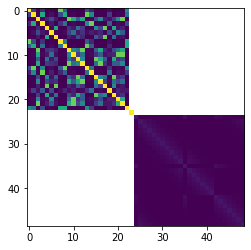

In [55]:
# build the prior; we are only doing this step to be able to look at this cool covariance matrix
# you could also record this to an external file if you really wanted to, but it is pretty huge due to the number of parameters
cov = pf.build_prior(fmt='none')

# and take a peak at a slice of the matrix
x = cov.x.copy()
x[x==0] = np.NaN
plt.imshow(x[-49:,-49:])

And now generate a prior parameter ensemble. This step is relevant for using pestpp-ies in subsequent tutorials.

In [56]:
pe = pf.draw(num_reals=100,use_specsim=True)# draw pars from the prior
pe.enforce() # enforces parameter bounds
pe.to_binary(os.path.join(template_ws,"prior.jcb")) #writes the paramter ensemble to binary file

# final tidy-up
pst.pestpp_options["ies_parameter_ensemble"] = "prior.jcb" #adds pest++ options to the control file
pst.write(os.path.join(template_ws, 'freyberg_mf6.pst')) # re-writes the control file with the new pest++ options

2022-03-02 11:49:38.415731 starting: drawing realizations
2022-03-02 11:49:38.518760 starting: spectral simulation for grid-scale pars
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72


2022-03-02 11:49:38.684521 starting: SpecSim: drawing 100 realization for group npf_k_layer1_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-02 11:49:38.721453 finished: SpecSim: drawing 100 realization for group npf_k_layer1_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.036932
2022-03-02 11:49:38.724442 starting: SpecSim: drawing 100 realization for group npf_k_layer2_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-02 11:49:38.760347 finished: SpecSim: drawing 100 realization for group npf_k_layer2_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.035905
2022-03-02 11:49:38.763353 starting: SpecSim: drawing 100 realization for group npf_k_layer3_gr with 706 pars, (log) variance 0.05428434

2022-03-02 11:49:38.879031 starting: SpecSim: drawing 100 realization for group npf_k33_layer3_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-02 11:49:38.914940 finished: SpecSim: drawing 100 realization for group npf_k33_layer3_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.035909
2022-03-02 11:49:38.917895 starting: SpecSim: drawing 100 realization for group sto_ss_layer2_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-02 11:49:38.952878 finished: SpecSim: drawing 100 realization for group sto_ss_layer2_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.034983
2022-03-02 11:49:38.955833 starting: SpecSim: drawing 100 realization for group sto_ss_layer3_gr with 706 pars, (log) variance 0.0

2022-03-02 11:49:39.071523 starting: SpecSim: drawing 100 realization for group rch_recharge_10_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-02 11:49:39.107469 finished: SpecSim: drawing 100 realization for group rch_recharge_10_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.035946
2022-03-02 11:49:39.110456 starting: SpecSim: drawing 100 realization for group rch_recharge_11_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-02 11:49:39.145363 finished: SpecSim: drawing 100 realization for group rch_recharge_11_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.034907
2022-03-02 11:49:39.148350 starting: SpecSim: drawing 100 realization for group rch_recharge_12_gr with 706 pars, (log) vari

2022-03-02 11:49:39.262062 starting: SpecSim: drawing 100 realization for group rch_recharge_15_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-02 11:49:39.297954 finished: SpecSim: drawing 100 realization for group rch_recharge_15_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.035892
2022-03-02 11:49:39.300951 starting: SpecSim: drawing 100 realization for group rch_recharge_16_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-02 11:49:39.335852 finished: SpecSim: drawing 100 realization for group rch_recharge_16_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.034901
2022-03-02 11:49:39.338846 starting: SpecSim: drawing 100 realization for group rch_recharge_17_gr with 706 pars, (log) vari

2022-03-02 11:49:39.456518 starting: SpecSim: drawing 100 realization for group rch_recharge_2_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-02 11:49:39.492438 finished: SpecSim: drawing 100 realization for group rch_recharge_2_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.035920
2022-03-02 11:49:39.495424 starting: SpecSim: drawing 100 realization for group rch_recharge_20_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-02 11:49:39.531322 finished: SpecSim: drawing 100 realization for group rch_recharge_20_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.035898
2022-03-02 11:49:39.533323 starting: SpecSim: drawing 100 realization for group rch_recharge_21_gr with 706 pars, (log) varian

2022-03-02 11:49:39.646024 starting: SpecSim: drawing 100 realization for group rch_recharge_24_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-02 11:49:39.680929 finished: SpecSim: drawing 100 realization for group rch_recharge_24_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.034905
2022-03-02 11:49:39.683920 starting: SpecSim: drawing 100 realization for group rch_recharge_25_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-02 11:49:39.719824 finished: SpecSim: drawing 100 realization for group rch_recharge_25_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.035904
2022-03-02 11:49:39.722829 starting: SpecSim: drawing 100 realization for group rch_recharge_3_gr with 706 pars, (log) varia

2022-03-02 11:49:39.837509 starting: SpecSim: drawing 100 realization for group rch_recharge_6_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-02 11:49:39.872415 finished: SpecSim: drawing 100 realization for group rch_recharge_6_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.034906
2022-03-02 11:49:39.875412 starting: SpecSim: drawing 100 realization for group rch_recharge_7_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-02 11:49:39.909317 finished: SpecSim: drawing 100 realization for group rch_recharge_7_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.033905
2022-03-02 11:49:39.912301 starting: SpecSim: drawing 100 realization for group rch_recharge_8_gr with 706 pars, (log) variance 

SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-02 11:49:40.171764 finished: spectral simulation for grid-scale pars took: 0:00:01.653004
2022-03-02 11:49:40.171764 starting: Drawing non-specsim pars
building diagonal cov


processing  name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0

working on pargroups ['npf_k_layer1_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['npf_k_layer2_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['npf_k_layer3_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['npf_k33_layer1_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['npf_k33_layer2_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['npf_k33_layer3_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['sto_ss_layer2_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['sto_ss_layer3_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['sto_sy_layer1_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['rch_recharge_1_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_10_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_11_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['rch_recharge_12_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_13_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_14_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['rch_recharge_15_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_16_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_17_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['rch_recharge_18_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_19_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_2_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['rch_recharge_20_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_21_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_22_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['rch_recharge_23_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_24_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_25_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_3_pp']


build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_4_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_5_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['rch_recharge_6_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_7_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_8_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['rch_recharge_9_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['ghbcond_gr']
build cov matrix
done
getting diag var cov 10
scaling full cov by diag var cov
working on pargroups ['ghbcond_gr']
build cov matrix
done
getting diag var cov 10
scaling full cov by diag var cov


working on pargroups ['ghbcond_gr']
build cov matrix
done
getting diag var cov 10
scaling full cov by diag var cov
working on pargroups ['sfrcond_gr']
build cov matrix
done
getting diag var cov 40
scaling full cov by diag var cov
processing  name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:60.0,anisotropy:1.0,bearing:0.0

working on pargroups ['wel_cst']
build cov matrix
done
getting diag var cov 25
scaling full cov by diag var cov


working on pargroups ['sfr_gr']
build cov matrix
done
getting diag var cov 25
scaling full cov by diag var cov
processing  name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0

working on pargroups ['ghbhead_gr']
build cov matrix
done
getting diag var cov 10
scaling full cov by diag var cov
working on pargroups ['ghbhead_gr']
build cov matrix
done
getting diag var cov 10
scaling full cov by diag var cov
working on pargroups ['ghbhead_gr']
build cov matrix


done
getting diag var cov 10
scaling full cov by diag var cov
adding remaining parameters to diagonal


2022-03-02 11:49:45.700388 finished: Drawing non-specsim pars took: 0:00:05.528624


2022-03-02 11:49:47.382968 finished: drawing realizations took: 0:00:08.967237


noptmax:0, npar_adj:25454, nnz_obs:920
